In [91]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score
import umap.umap_ as umap

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import warnings
import urllib.request
from PIL import Image
%matplotlib inline

warnings.filterwarnings("ignore")

# sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [92]:
def group_by_champions(df):
    df_champs = df.drop(['championId'], axis=1).groupby("championName").mean().reset_index(level=0)
    x = df_champs.iloc[:,1:]
    y = df_champs.iloc[:,:1]
    return x, y

In [93]:
def standarize_df(df):
    x_role, y_role = group_by_champions(df)
    ## standarize
    role_std_model = StandardScaler()
    x_role_std = role_std_model.fit_transform(x_role)
    
    return x_role_std, y_role

In [94]:
general_soloq = pd.read_csv("../data/soloq/clean/general_soloq.csv")

top_soloq = pd.read_csv("../data/soloq/clean/top_soloq.csv")
jungle_soloq = pd.read_csv("../data/soloq/clean/jungle_soloq.csv")
mid_soloq = pd.read_csv("../data/soloq/clean/mid_soloq.csv")
bottom_soloq = pd.read_csv("../data/soloq/clean/bottom_soloq.csv")
utility_soloq = pd.read_csv("../data/soloq/clean/utility_soloq.csv")

In [95]:
def kmeans_clustering_elbow(df, total_k = 20):
    distorsions = []
    K = range(1, total_k)
    for k in K:
        kmean_model = KMeans(n_clusters=k)
        kmean_model.fit(df)
        distorsions.append(kmean_model.inertia_)
        
    plt.figure(figsize=(16,8))
    plt.plot(K, distorsions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [96]:
def apply_pca(df, variance_explained_specified):
    pca = PCA( variance_explained_specified )
    df = pca.fit_transform(df)
    return df

def apply_umap(df, n_components):
    reducer = umap.UMAP(n_components= n_components)
    df = reducer.fit_transform(df)
    return df

In [97]:
def silhouette_analysis(range_n_clusters, x_general):
    
    for n_clusters in range_n_clusters:
        fig, (ax1, ax2) = plt.subplots(1,2)
        fig.set_size_inches(18, 7)

        # silhouette plot
        ax1.set_xlim([-1, 1])
        ax1.set_ylim([0, len(x_general) + (n_clusters + 1) * 10])
        # initialize the clusters
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(x_general)
        # silhouette_score that gives the average value for all the samples
        # (this gives a perspective into the density and separation of the formed clusters).
        silhouette_avg = silhouette_score(x_general, cluster_labels)
        labels = clusterer.labels_
        calinski_harabasz = metrics.calinski_harabasz_score(x_general, labels)
        davies_bouldin = davies_bouldin_score(x_general, labels)
        print("For n_clusters =",
             n_clusters,
             "Average silhouette_score:",
             silhouette_avg,
             ", Calinski Harabasz score:",
             calinski_harabasz,
             ", Davies Bouldin:",
             davies_bouldin)
        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(x_general, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )
            # label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            # compute the new y_lower for next plot
            y_lower = y_upper + 10

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # the vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])
        ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(
            x_general[:, 0], x_general[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
        )
        # label the clusters
        centers = clusterer.cluster_centers_
        # draw white circles at cluster centers
        ax2.scatter(
            centers[:, 0],
            centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=200,
            edgecolor="k",
        )

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(
            "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
            % n_clusters,
            fontsize=14,
            fontweight="bold",
        )
    plt.show()

In [98]:
def pca_kmeans(x_role, y_role, variance_explained_specified=0.85, k = 2 ):
    ## pca
    pca = PCA( variance_explained_specified )
    role_principal_components = pca.fit_transform(x_role)
    ## k-means
    # kmeans_clustering_elbow(role_principal_components, total_k = 20)
    role_kmeans_model = KMeans(n_clusters= k ).fit(role_principal_components)
    y_role['kmeans'] = role_kmeans_model.predict(role_principal_components)
    y_role
    role_champions_list = y_role.groupby('kmeans')['championName'].apply(list).to_dict()
    
    return y_role, role_champions_list, role_principal_components

In [99]:
def umap_kmeans(x_role, y_role, n_comps= 2 , k = 2 ):
    ## umap
    reducer = umap.UMAP(n_components= n_comps)
    role_umap = reducer.fit_transform(x_role)
    ## k-means
    # kmeans_clustering_elbow(role_umap, total_k = 20)
    role_kmeans_model = KMeans(n_clusters= k ).fit(role_umap)
    y_role['kmeans'] = role_kmeans_model.predict(role_umap)
    role_champions_list = y_role.groupby('kmeans')['championName'].apply(list).to_dict()
    
    return y_role, role_champions_list, role_umap

In [116]:
def print_kmeans(y_role):
    for category in pd.unique(y_role['kmeans']):
        print(category)
        for champion in pd.unique(y_role[y_role['kmeans'] == category]['championName']):
            print(champion)
        print("")

### General PCA

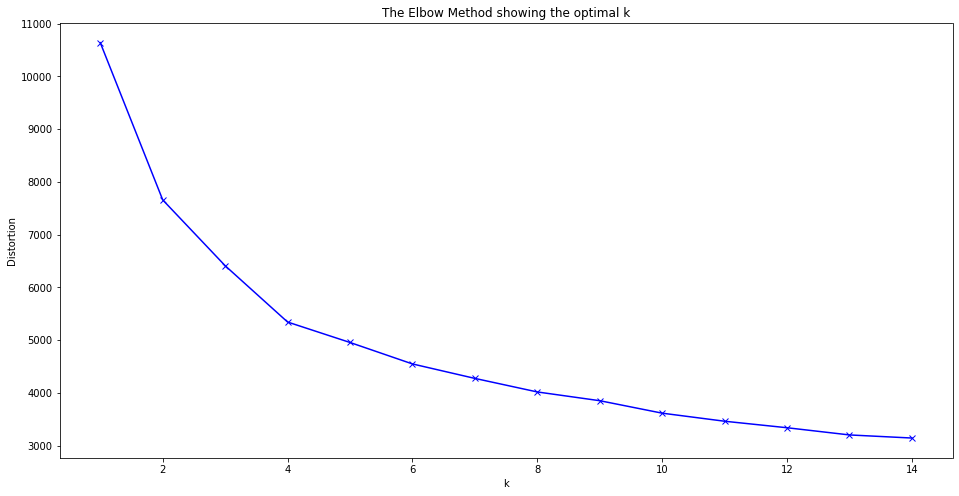

In [100]:
# general pca
x_general, y_general = standarize_df(general_soloq)
x_general_pca = apply_pca(x_general, 0.85)
kmeans_clustering_elbow(x_general_pca, total_k = 15)    

For n_clusters = 3 Average silhouette_score: 0.23472958050455817 , Calinski Harabasz score: 46.789132440519076 , Davies Bouldin: 1.5168327223756277
For n_clusters = 4 Average silhouette_score: 0.26390741662207157 , Calinski Harabasz score: 46.557544251191274 , Davies Bouldin: 1.4076435470032422
For n_clusters = 5 Average silhouette_score: 0.24510145310195733 , Calinski Harabasz score: 40.32266179758662 , Davies Bouldin: 1.47563991298363
For n_clusters = 6 Average silhouette_score: 0.23427953181159358 , Calinski Harabasz score: 36.6183820080983 , Davies Bouldin: 1.5817185579293964
For n_clusters = 7 Average silhouette_score: 0.23664970303068952 , Calinski Harabasz score: 34.499266886017864 , Davies Bouldin: 1.22966762927114
For n_clusters = 8 Average silhouette_score: 0.20038118231131383 , Calinski Harabasz score: 31.144819981128567 , Davies Bouldin: 1.6865914436836797
For n_clusters = 9 Average silhouette_score: 0.22388443873713573 , Calinski Harabasz score: 31.153487131758858 , Davies

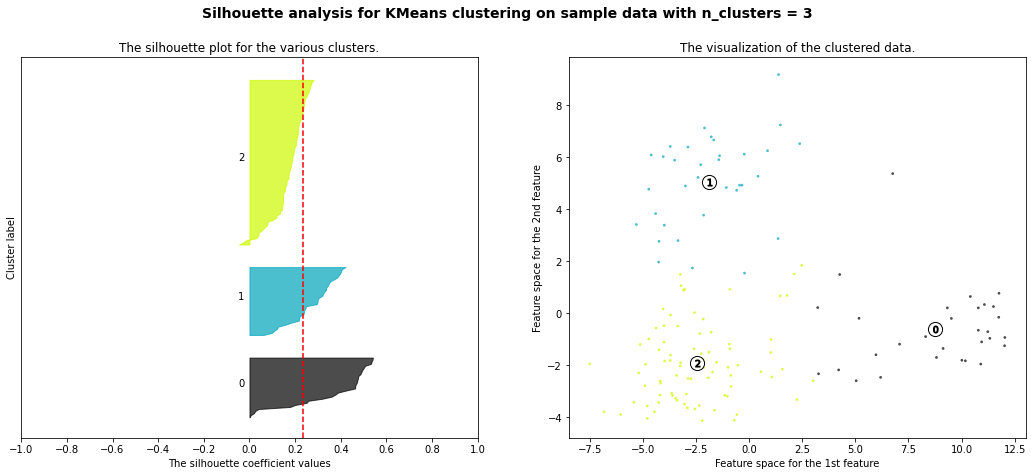

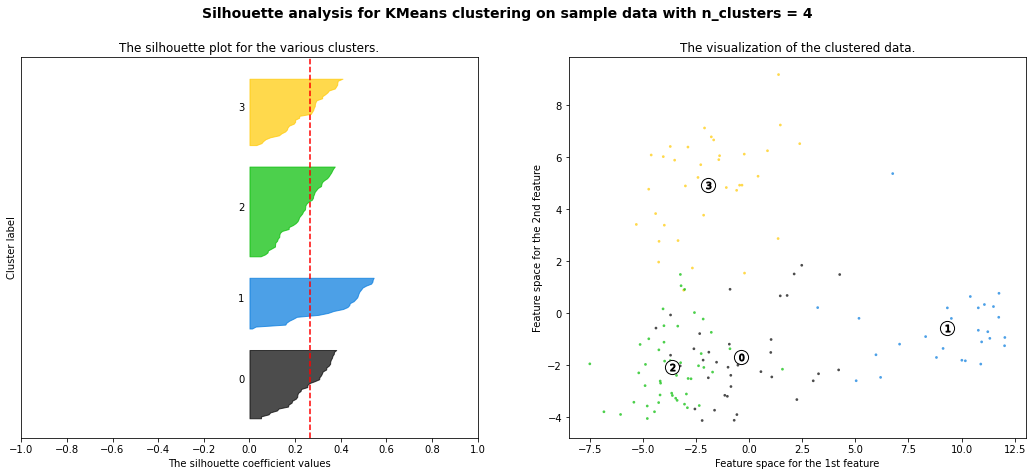

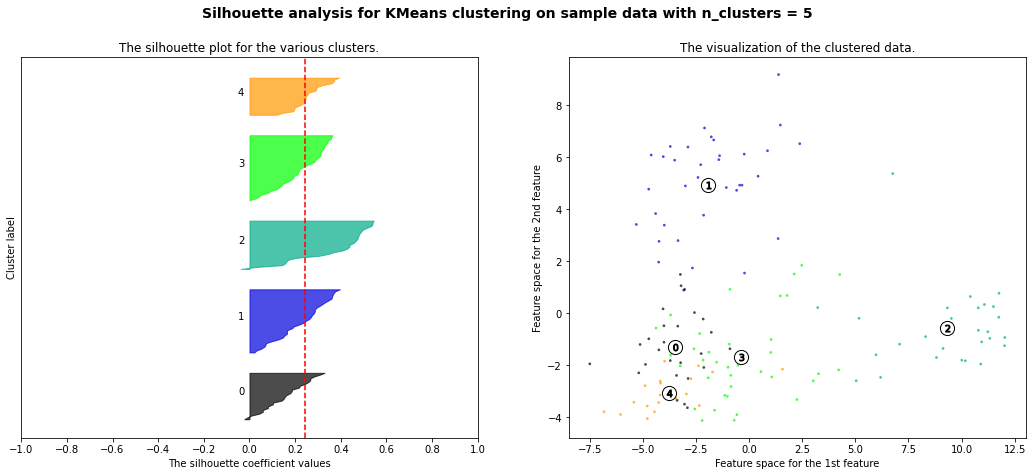

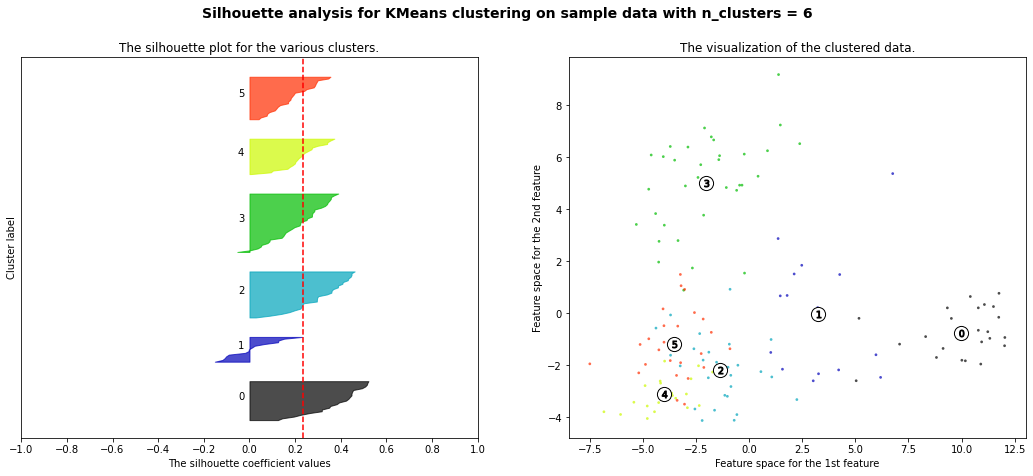

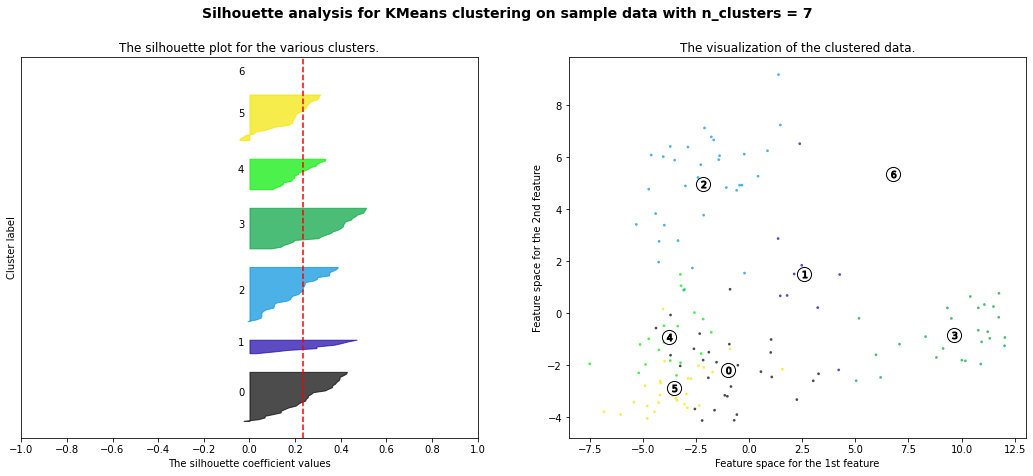

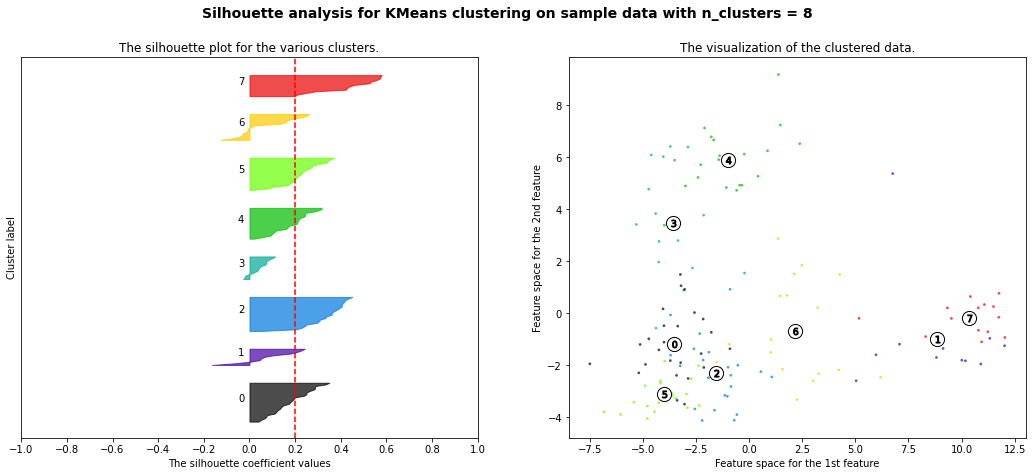

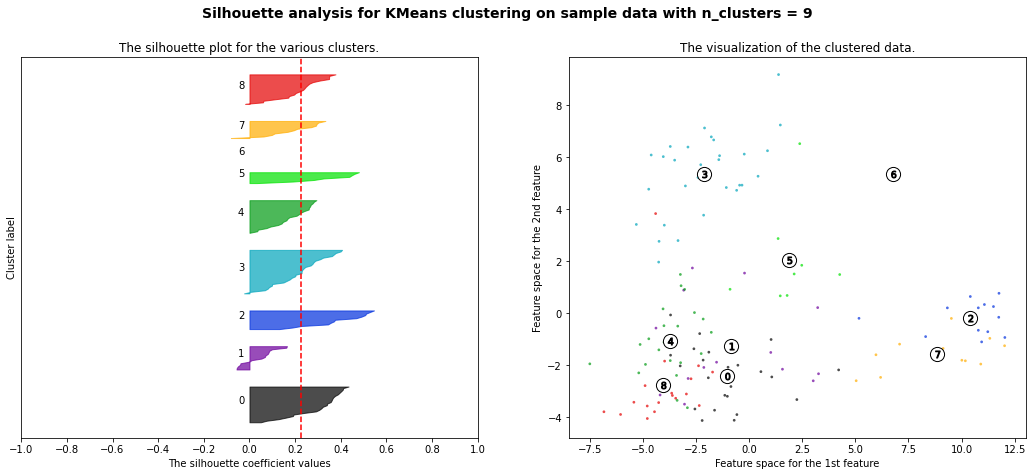

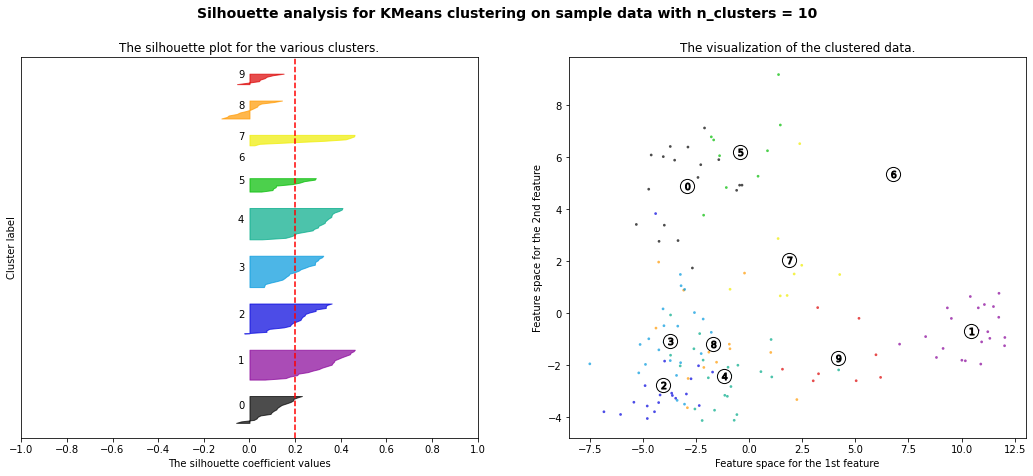

In [101]:
silhouette_analysis([3, 4, 5, 6, 7, 8, 9, 10], x_general_pca)

### General UMAP

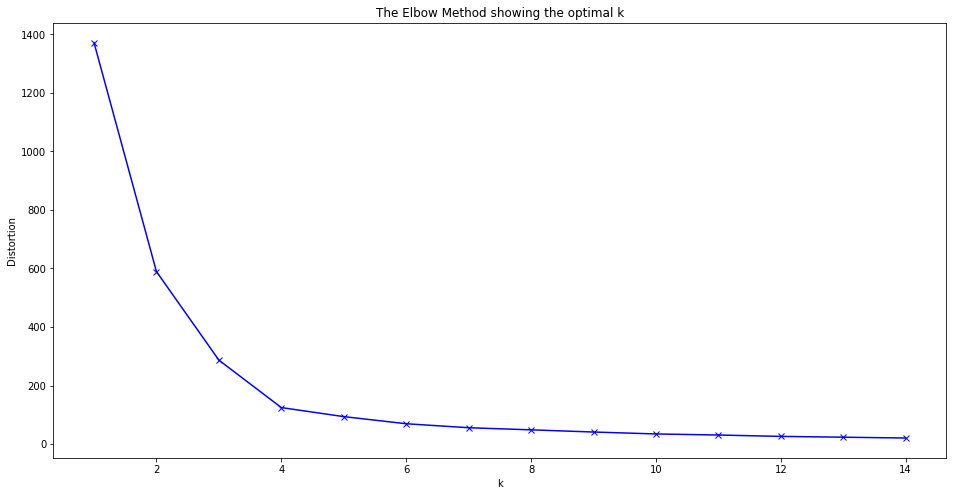

In [102]:
# general pca
x_general, y_general = standarize_df(general_soloq)
x_general_umap = apply_umap(x_general, 2)
kmeans_clustering_elbow(x_general_umap, total_k = 15) 

For n_clusters = 2 Average silhouette_score: 0.5669255 , Calinski Harabasz score: 189.8841007149896 , Davies Bouldin: 0.46992033100474534
For n_clusters = 3 Average silhouette_score: 0.5392159 , Calinski Harabasz score: 268.6891751998161 , Davies Bouldin: 0.7172992087287962
For n_clusters = 4 Average silhouette_score: 0.6471755 , Calinski Harabasz score: 470.51425011955524 , Davies Bouldin: 0.4901741706138274
For n_clusters = 5 Average silhouette_score: 0.6113096 , Calinski Harabasz score: 477.4461963822656 , Davies Bouldin: 0.5693369580098497


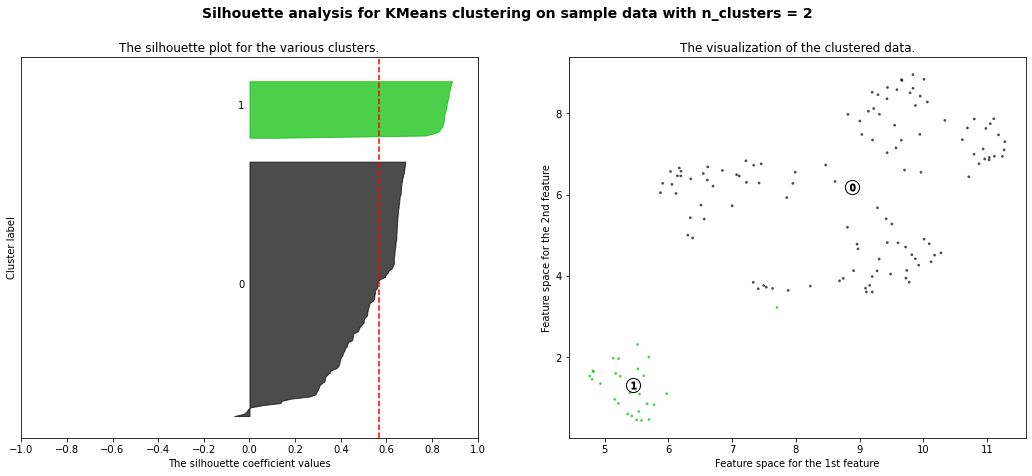

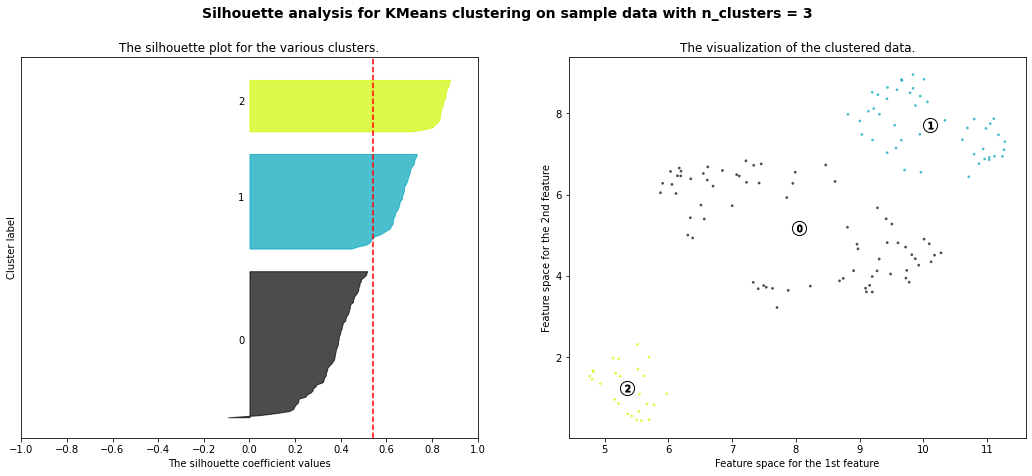

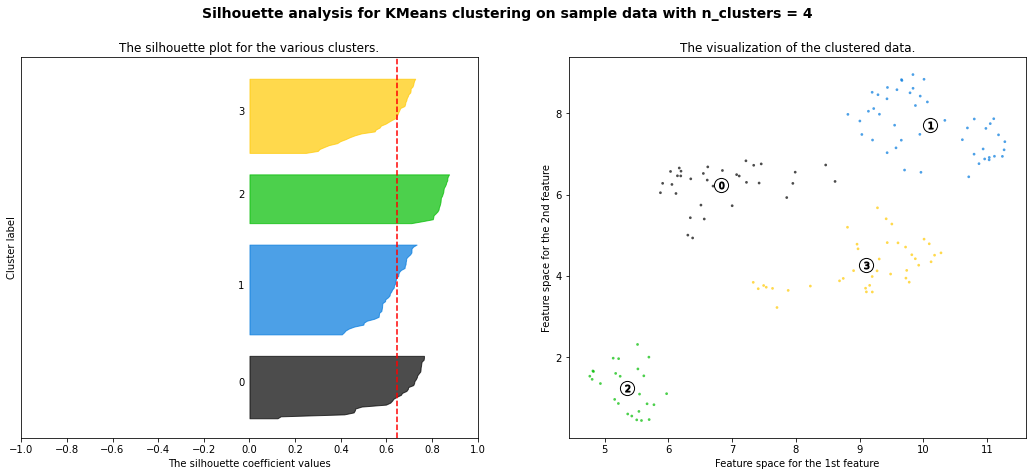

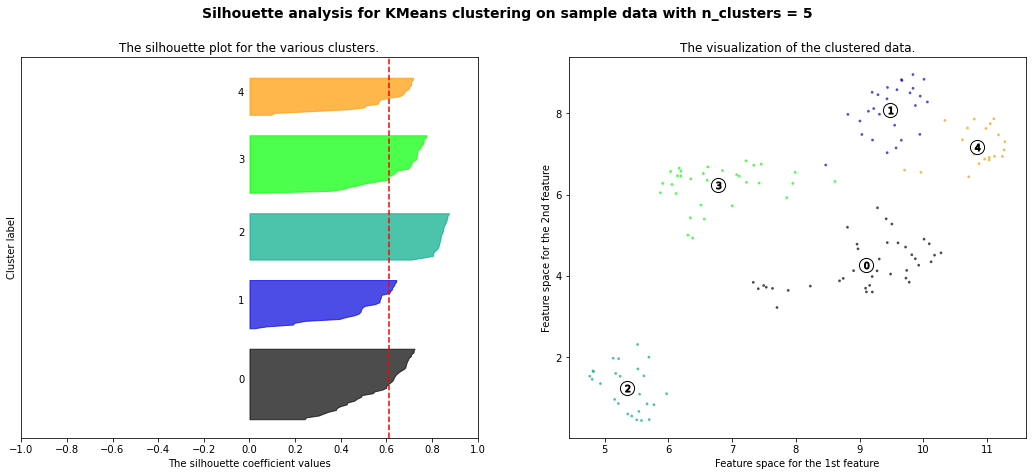

In [103]:
silhouette_analysis([2, 3, 4, 5], x_general_umap)

### Top

For n_clusters = 2 Average silhouette_score: 0.29536599157185867 , Calinski Harabasz score: 14.342962843773833 , Davies Bouldin: 1.2306964548740427
For n_clusters = 3 Average silhouette_score: 0.1401719405761588 , Calinski Harabasz score: 10.589068015118555 , Davies Bouldin: 1.968435673531219
For n_clusters = 4 Average silhouette_score: 0.14824436877903086 , Calinski Harabasz score: 8.95866583942756 , Davies Bouldin: 1.7990045675369966
For n_clusters = 5 Average silhouette_score: 0.10958331868295076 , Calinski Harabasz score: 7.571142404839624 , Davies Bouldin: 1.9021715975002724
For n_clusters = 6 Average silhouette_score: 0.13627619277525801 , Calinski Harabasz score: 7.39383789491943 , Davies Bouldin: 1.703680023718719
For n_clusters = 7 Average silhouette_score: 0.15585267035568087 , Calinski Harabasz score: 7.215575747114661 , Davies Bouldin: 1.600432494968731
For n_clusters = 8 Average silhouette_score: 0.14693941512478237 , Calinski Harabasz score: 7.01793212452169 , Davies Boul

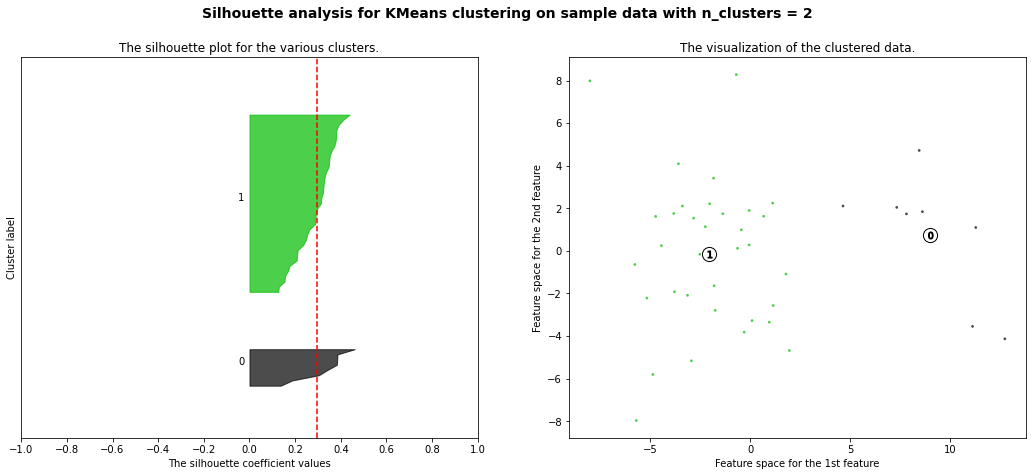

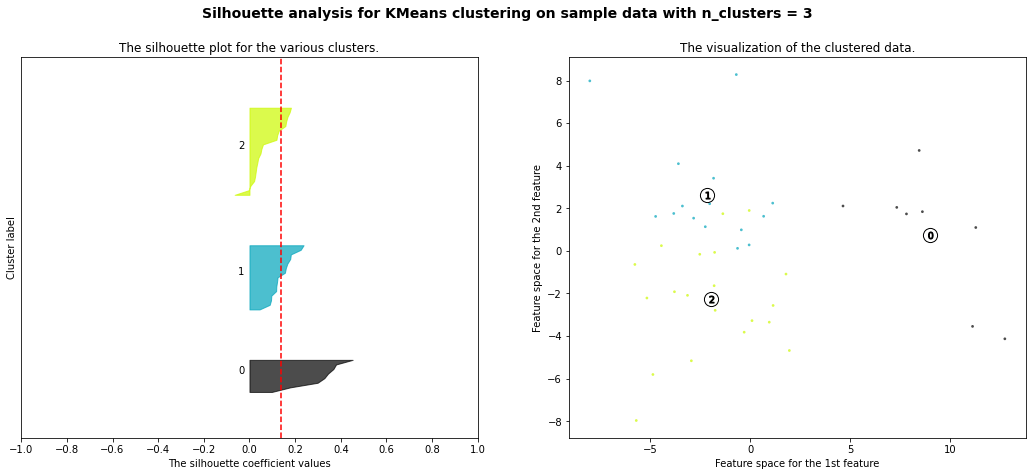

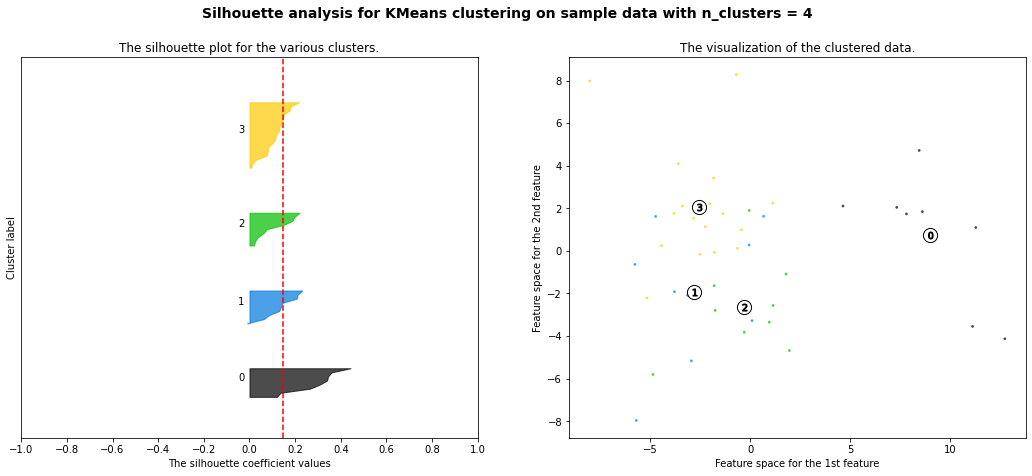

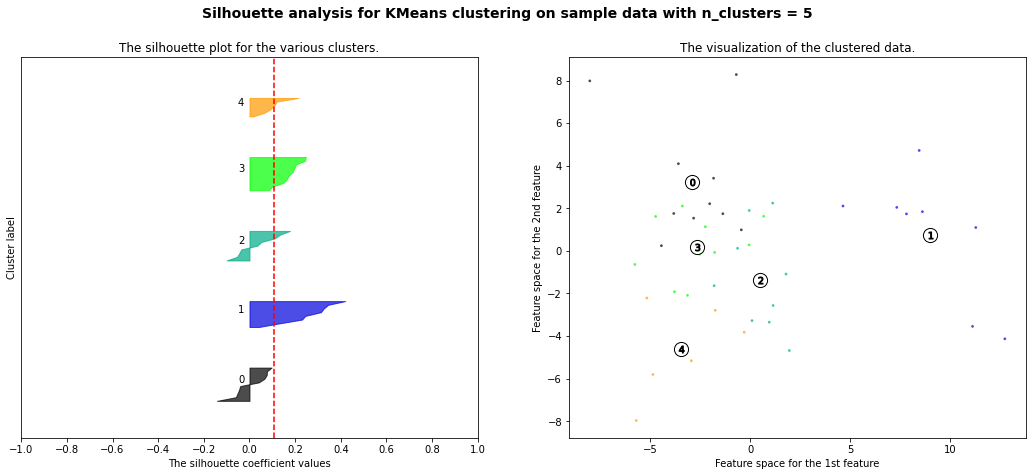

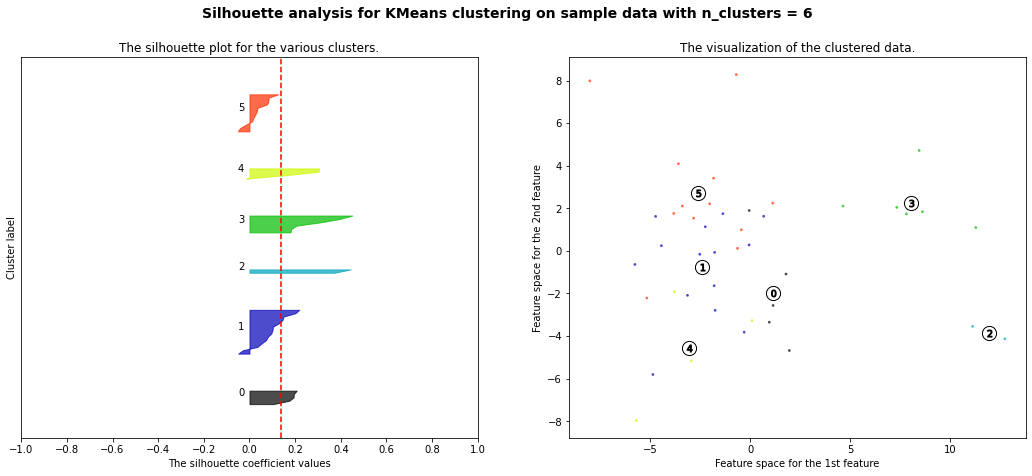

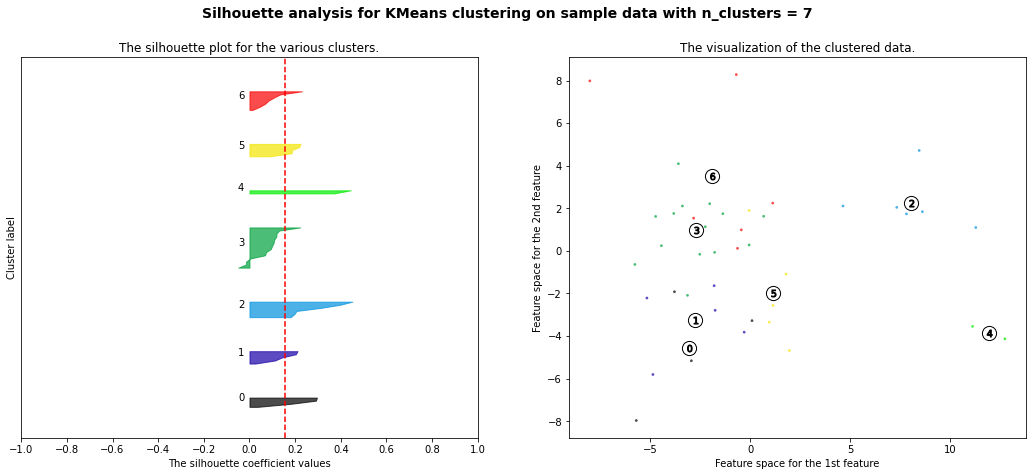

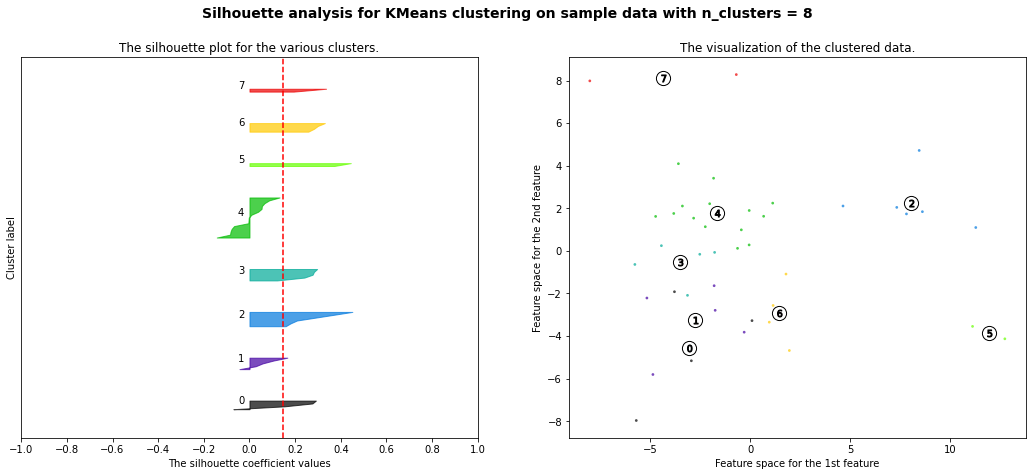

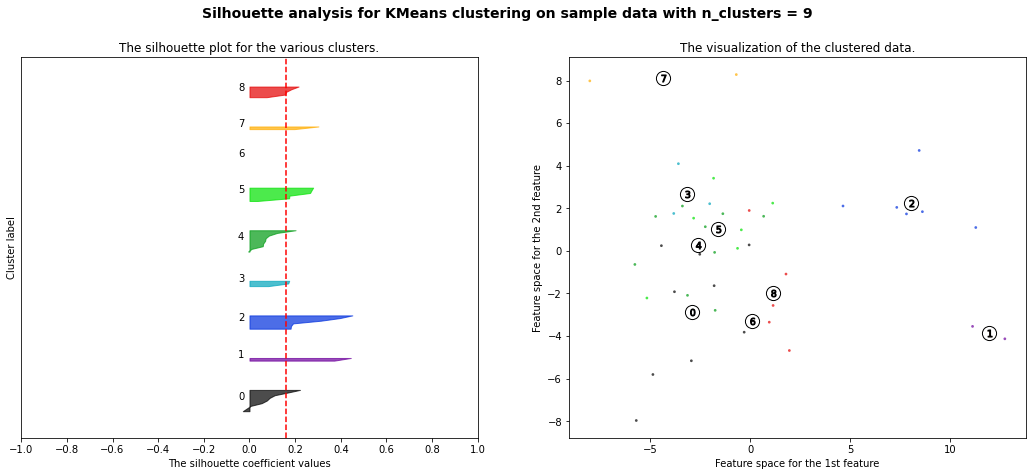

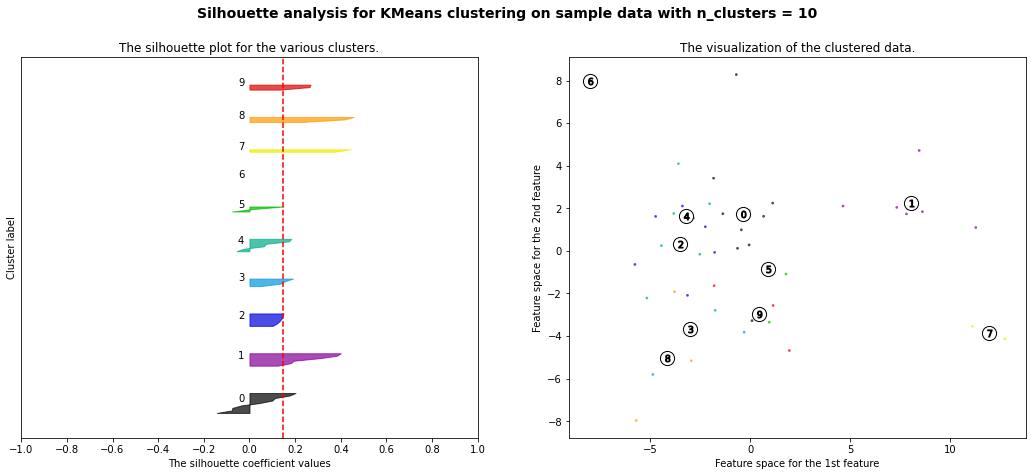

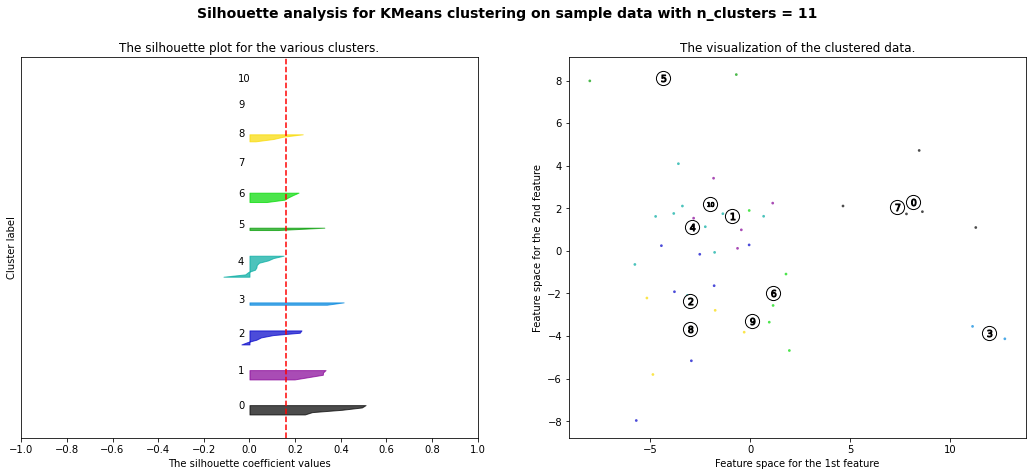

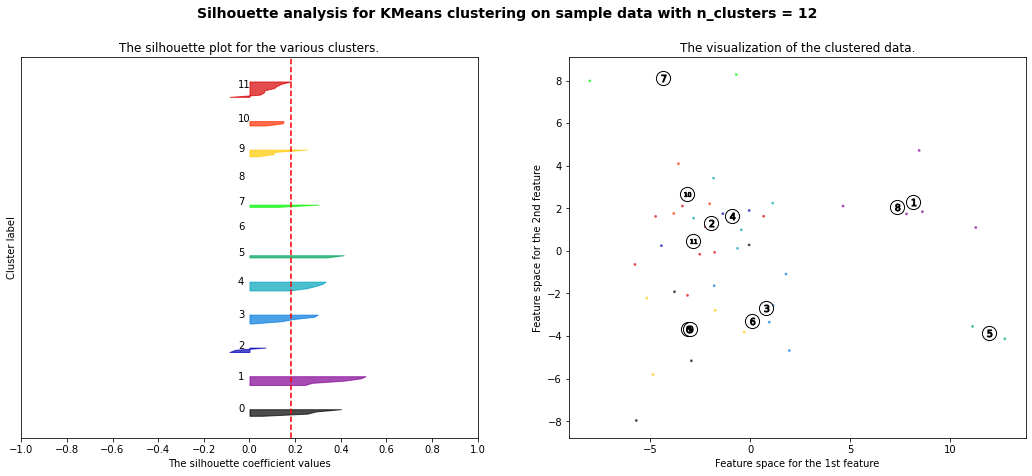

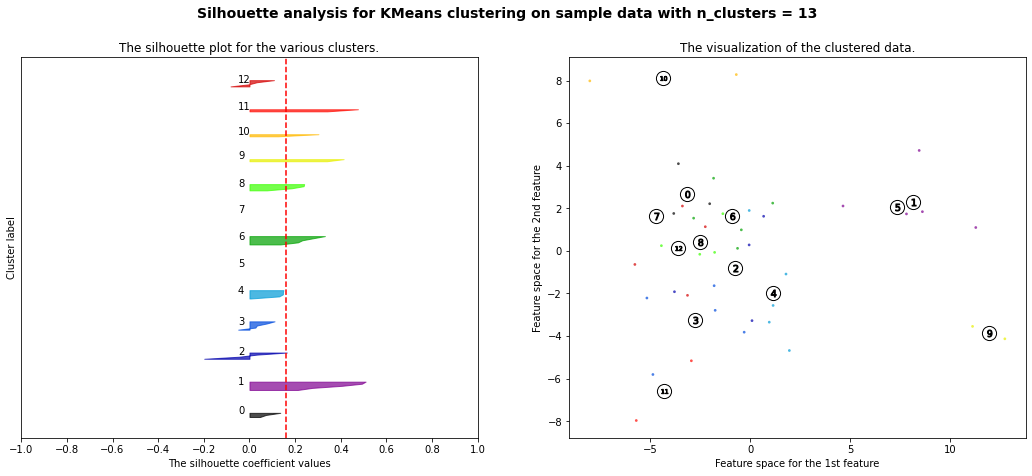

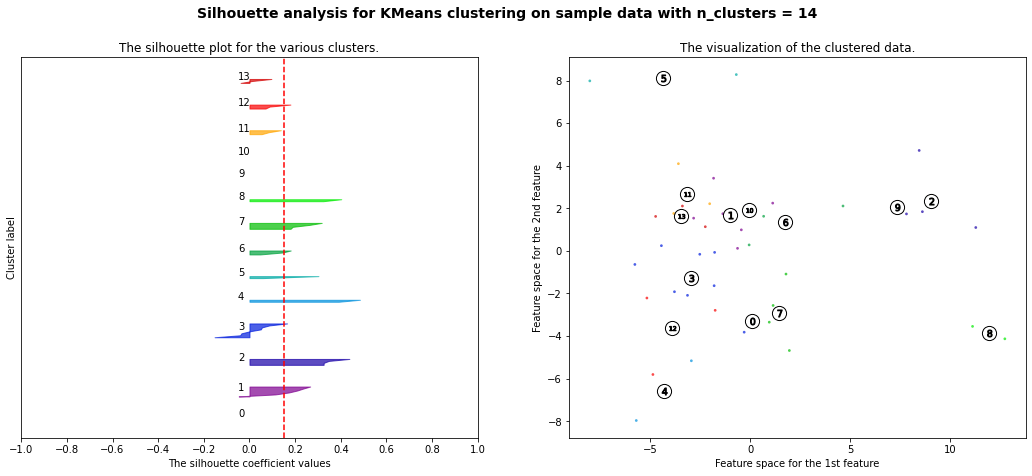

In [104]:
x_top, y_top = standarize_df(top_soloq)
# pca
x_top_pca = apply_pca(x_top, 0.85)
# kmeans_clustering_elbow(x_top_pca, total_k = 15) 
silhouette_analysis([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], x_top_pca)

For n_clusters = 2 Average silhouette_score: 0.4401296 , Calinski Harabasz score: 52.973162598356744 , Davies Bouldin: 0.829670122643955
For n_clusters = 3 Average silhouette_score: 0.41042298 , Calinski Harabasz score: 50.04076781879363 , Davies Bouldin: 0.8749043498849955
For n_clusters = 4 Average silhouette_score: 0.40922272 , Calinski Harabasz score: 53.80461208843578 , Davies Bouldin: 0.8148822952612733
For n_clusters = 5 Average silhouette_score: 0.42700133 , Calinski Harabasz score: 63.933119078171416 , Davies Bouldin: 0.7708844650633272
For n_clusters = 6 Average silhouette_score: 0.4134993 , Calinski Harabasz score: 66.20695365954501 , Davies Bouldin: 0.7273456826183096
For n_clusters = 7 Average silhouette_score: 0.3906547 , Calinski Harabasz score: 64.69597447793444 , Davies Bouldin: 0.7628834179919882
For n_clusters = 8 Average silhouette_score: 0.388416 , Calinski Harabasz score: 61.20663855773077 , Davies Bouldin: 0.733891145162919


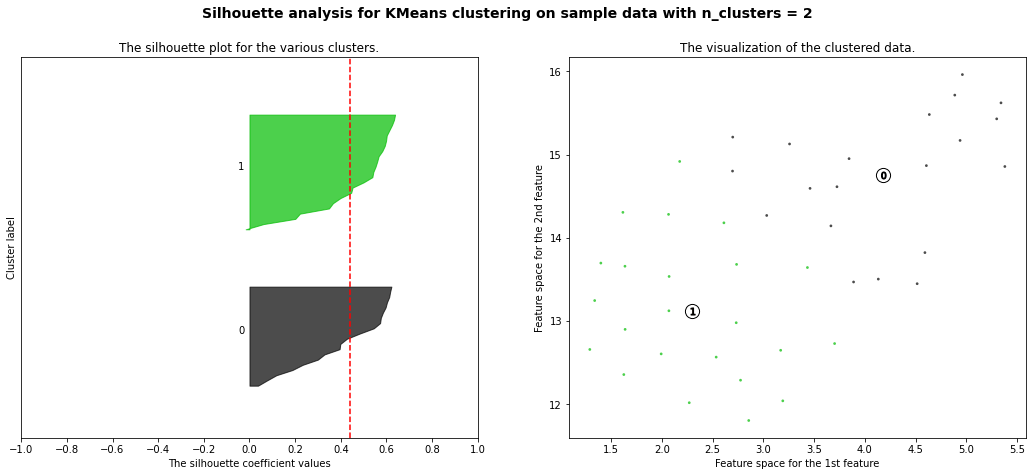

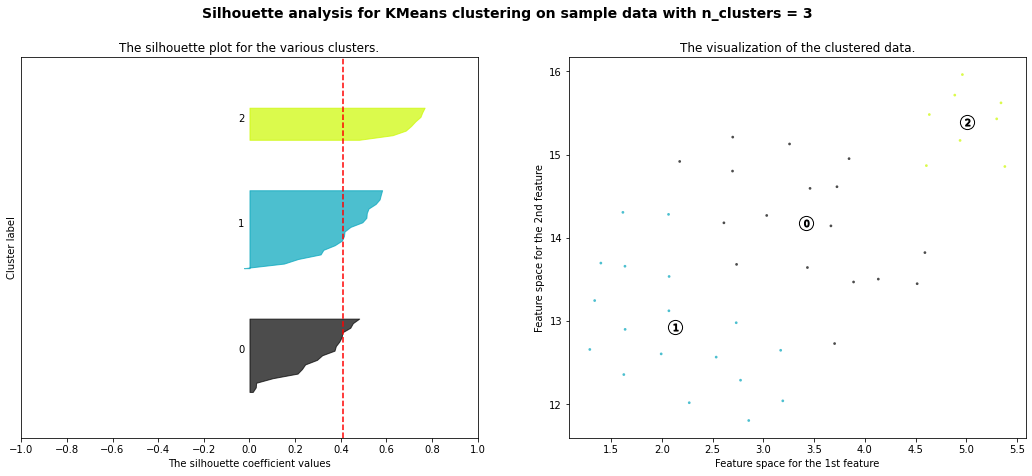

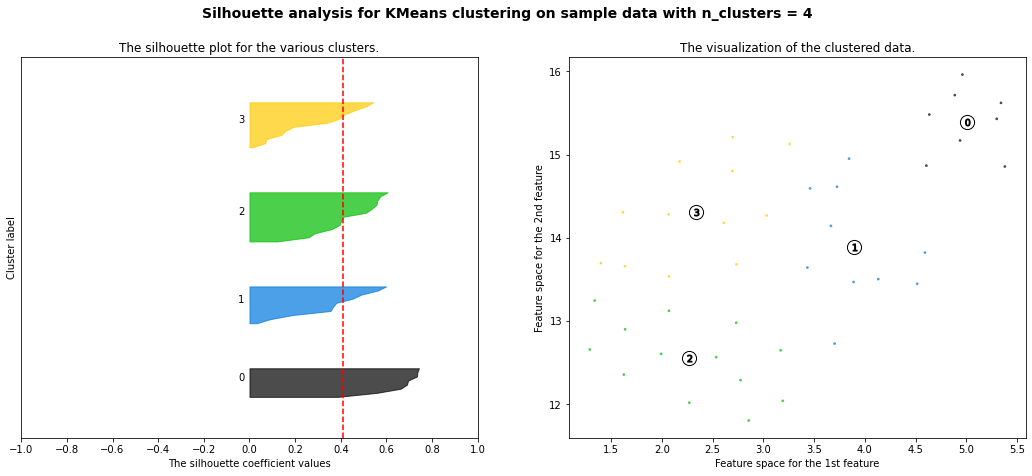

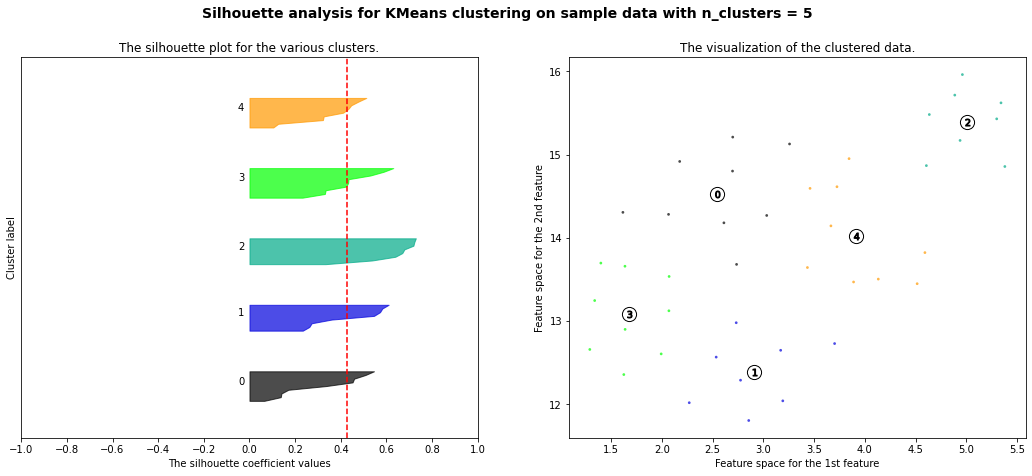

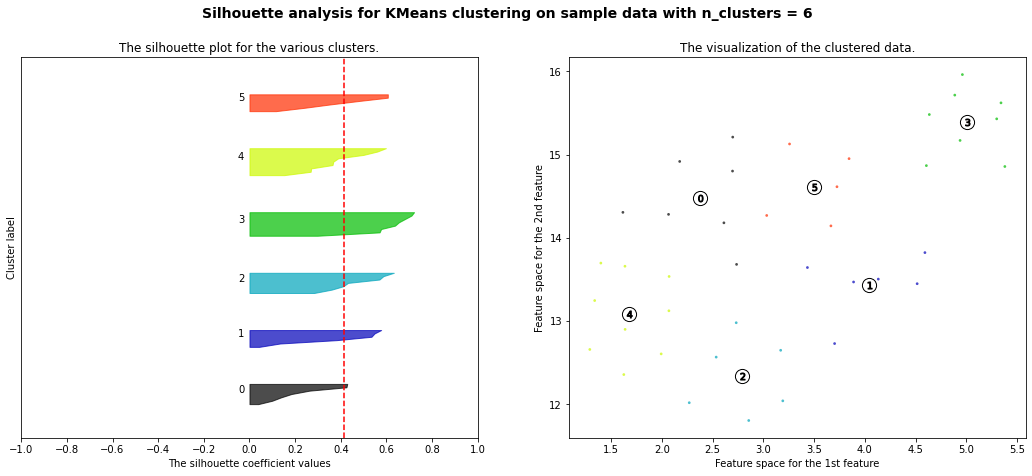

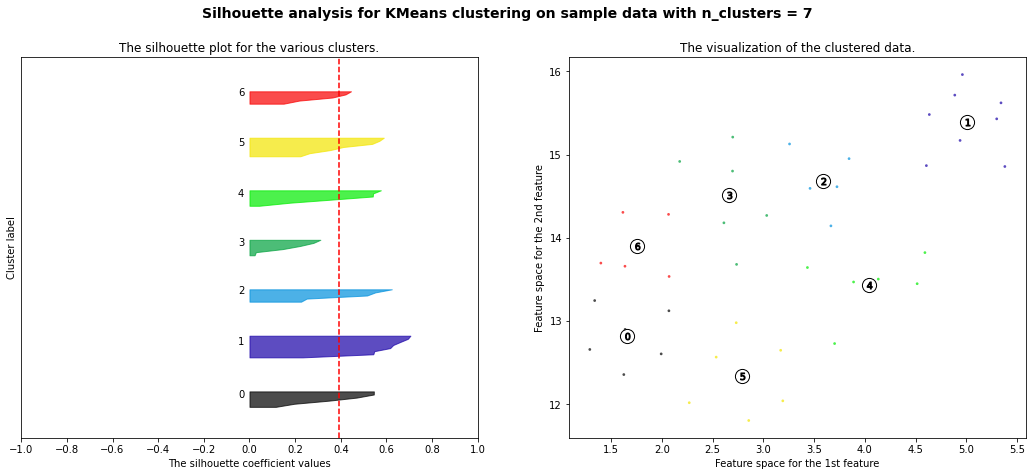

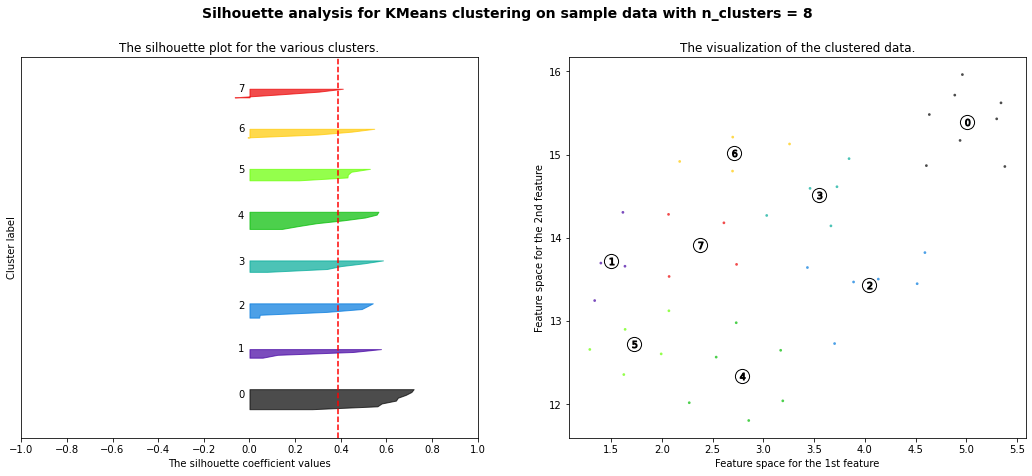

In [105]:
# umap
x_top_umap = apply_umap(x_top, 2)
# kmeans_clustering_elbow(x_top_umap, total_k = 15) 
silhouette_analysis([2, 3, 4, 5, 6, 7, 8], x_top_umap)

### Jungle

For n_clusters = 2 Average silhouette_score: 0.18957595573803082 , Calinski Harabasz score: 8.976082358160893 , Davies Bouldin: 1.7129846699556976
For n_clusters = 3 Average silhouette_score: 0.14719273111604447 , Calinski Harabasz score: 8.269400479350075 , Davies Bouldin: 1.3604659146329603
For n_clusters = 4 Average silhouette_score: 0.11272276575949092 , Calinski Harabasz score: 6.8238464603704525 , Davies Bouldin: 1.7152925626251563
For n_clusters = 5 Average silhouette_score: 0.09773628423246589 , Calinski Harabasz score: 6.715690360544826 , Davies Bouldin: 1.6951124760982004
For n_clusters = 6 Average silhouette_score: 0.0976048202012967 , Calinski Harabasz score: 6.24128278444862 , Davies Bouldin: 1.5540703011613086
For n_clusters = 7 Average silhouette_score: 0.09356741760665176 , Calinski Harabasz score: 5.664986786669514 , Davies Bouldin: 1.454705323632518
For n_clusters = 8 Average silhouette_score: 0.104544384787518 , Calinski Harabasz score: 5.983504970547461 , Davies Bou

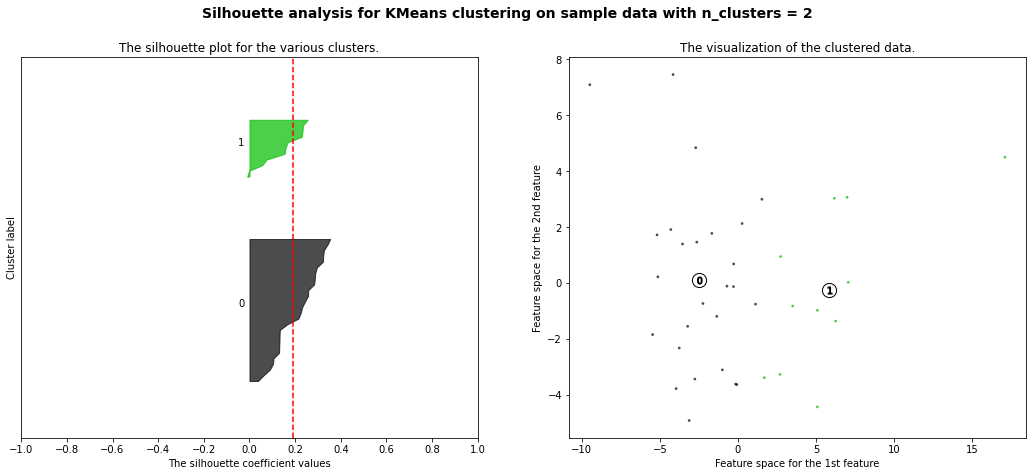

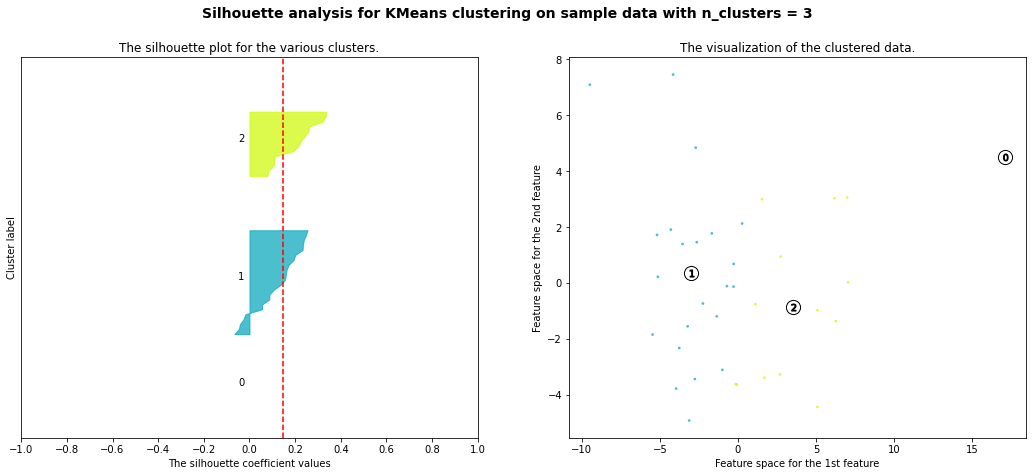

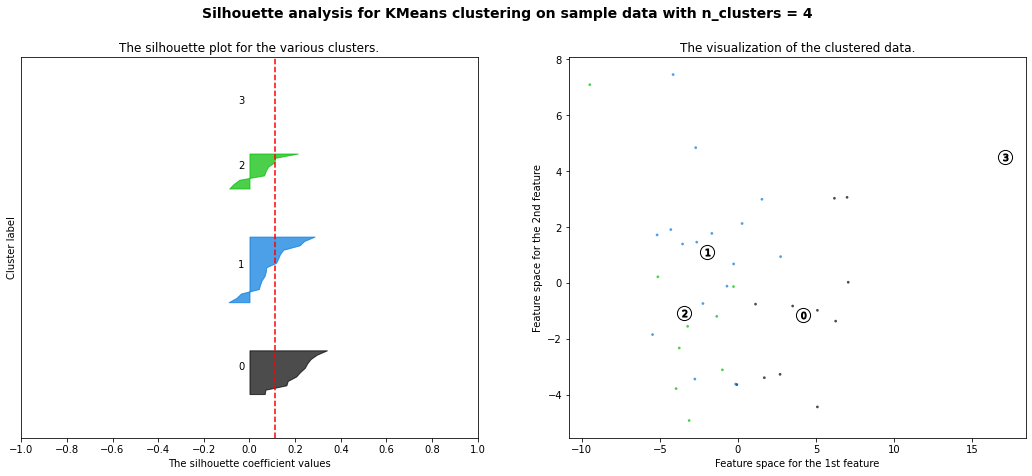

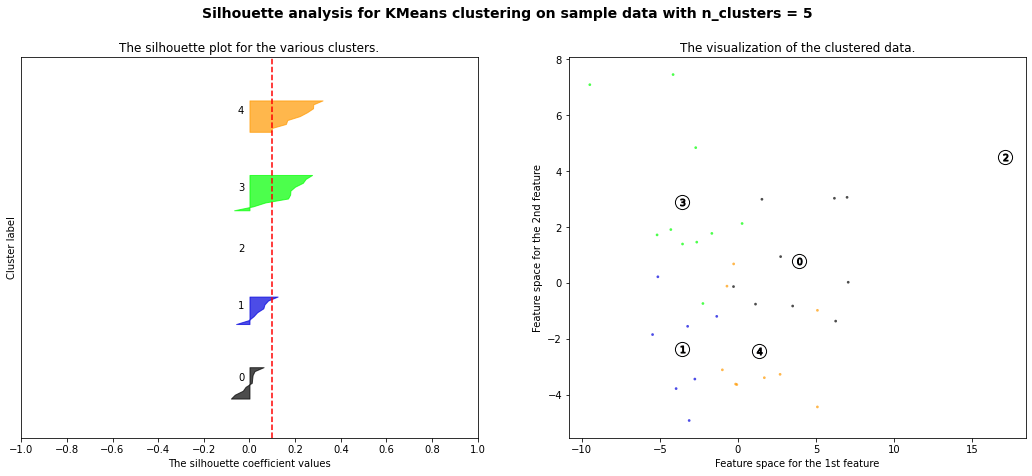

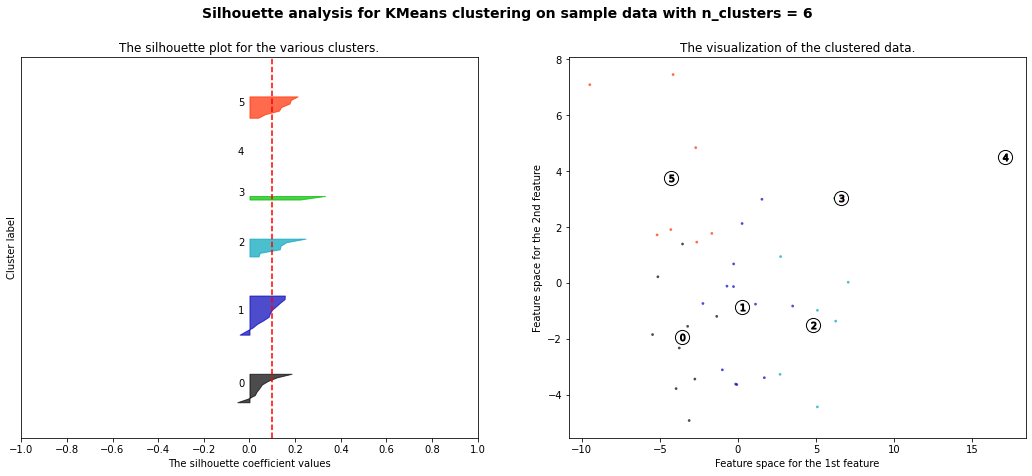

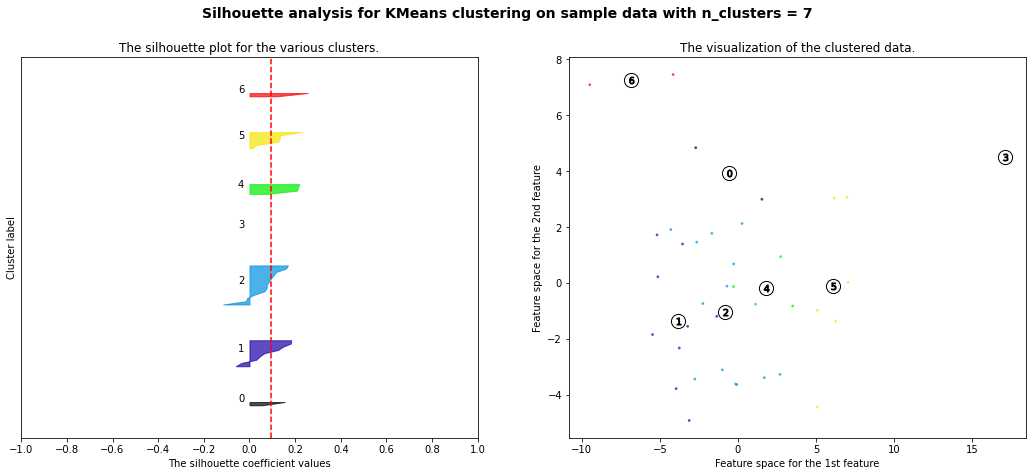

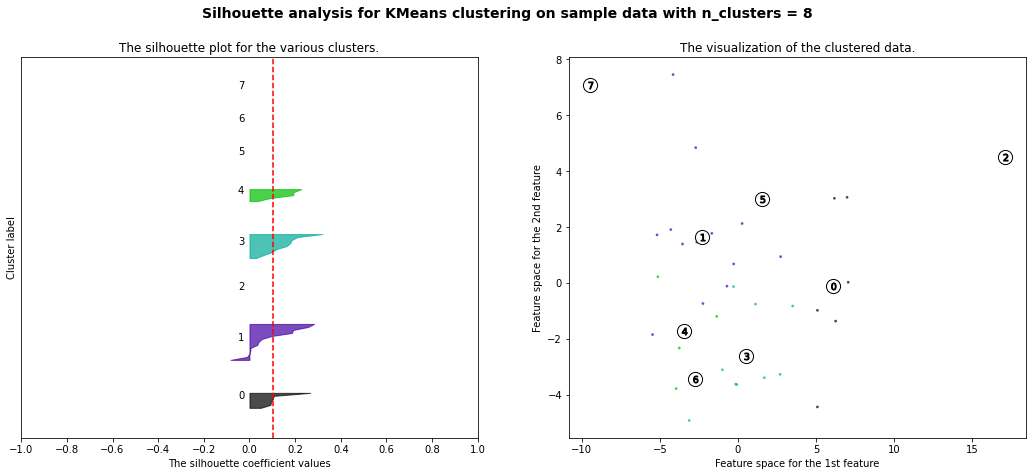

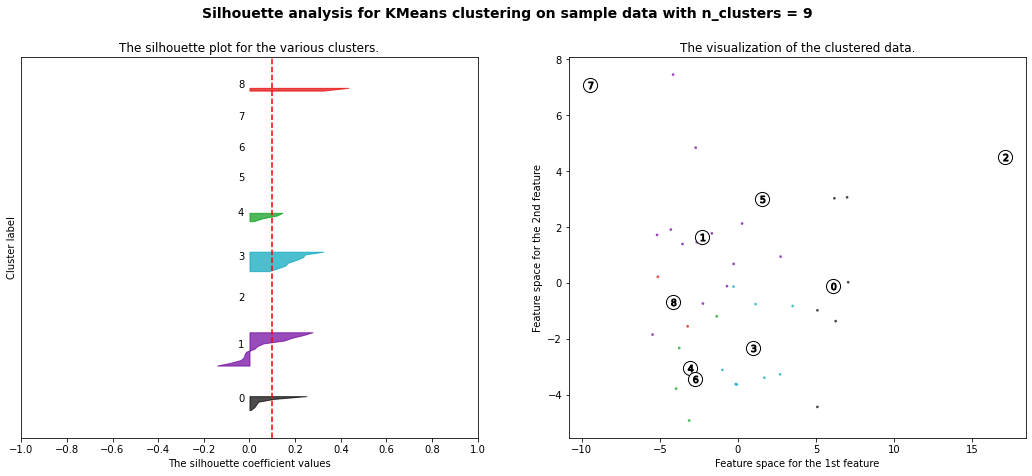

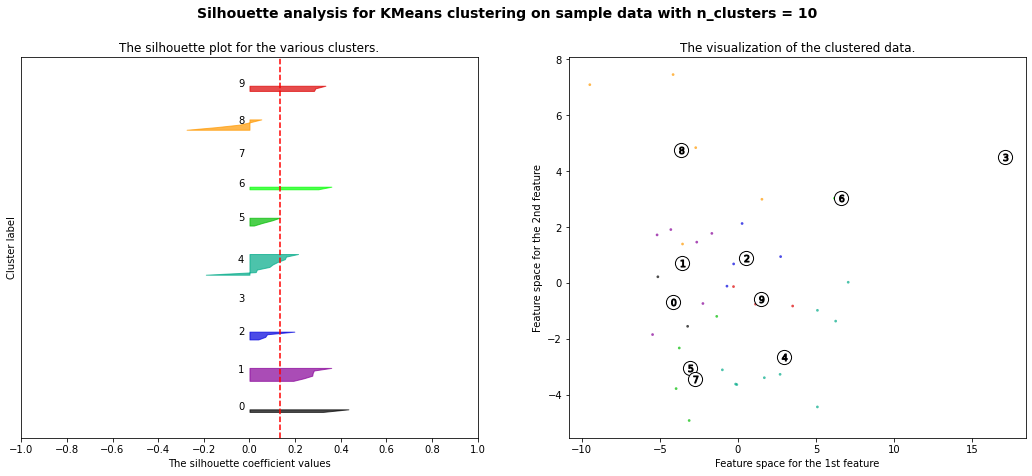

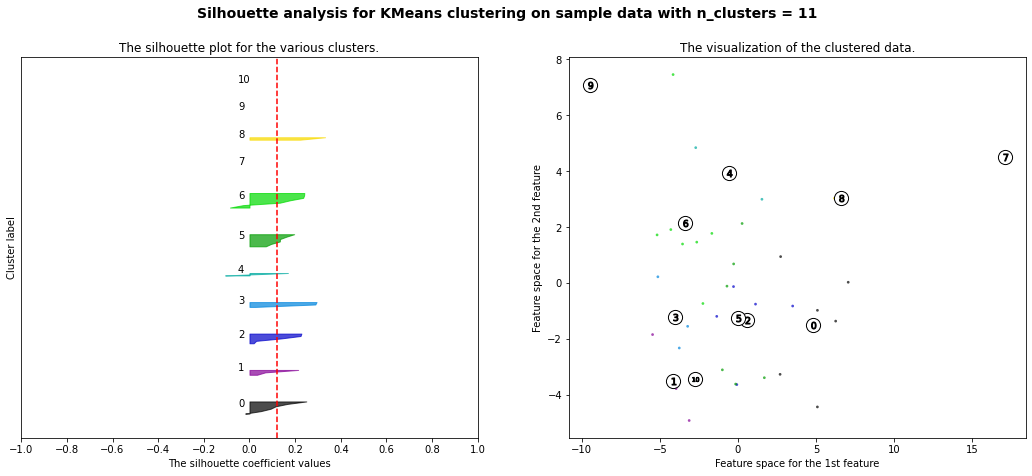

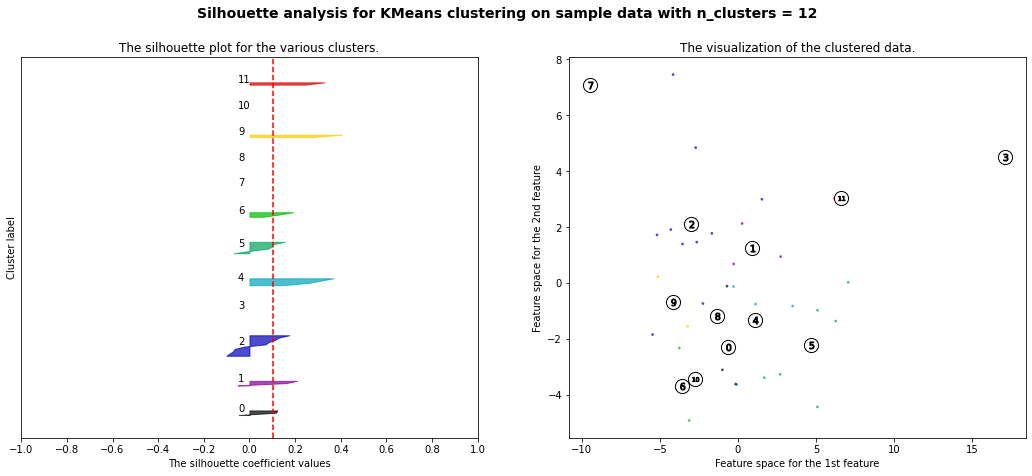

In [106]:
x_jungle, y_jungle = standarize_df(jungle_soloq)
# pca
x_jungle_pca = apply_pca(x_jungle, 0.85)
# kmeans_clustering_elbow(x_jungle_pca, total_k = 30)
silhouette_analysis([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], x_jungle_pca)

For n_clusters = 2 Average silhouette_score: 0.45449674 , Calinski Harabasz score: 43.31145320447468 , Davies Bouldin: 0.8377734067488886
For n_clusters = 3 Average silhouette_score: 0.43079135 , Calinski Harabasz score: 45.18335204413141 , Davies Bouldin: 0.7894923740840064
For n_clusters = 4 Average silhouette_score: 0.3923475 , Calinski Harabasz score: 42.456843692179845 , Davies Bouldin: 0.7724511541840009
For n_clusters = 5 Average silhouette_score: 0.4195575 , Calinski Harabasz score: 49.12717023340453 , Davies Bouldin: 0.7058102418266979
For n_clusters = 6 Average silhouette_score: 0.4122149 , Calinski Harabasz score: 49.62582183396051 , Davies Bouldin: 0.7347460107504372
For n_clusters = 7 Average silhouette_score: 0.4162128 , Calinski Harabasz score: 47.1264040598812 , Davies Bouldin: 0.6877488991819902
For n_clusters = 8 Average silhouette_score: 0.37610024 , Calinski Harabasz score: 48.24811973659321 , Davies Bouldin: 0.7775498443875266
For n_clusters = 9 Average silhouette_

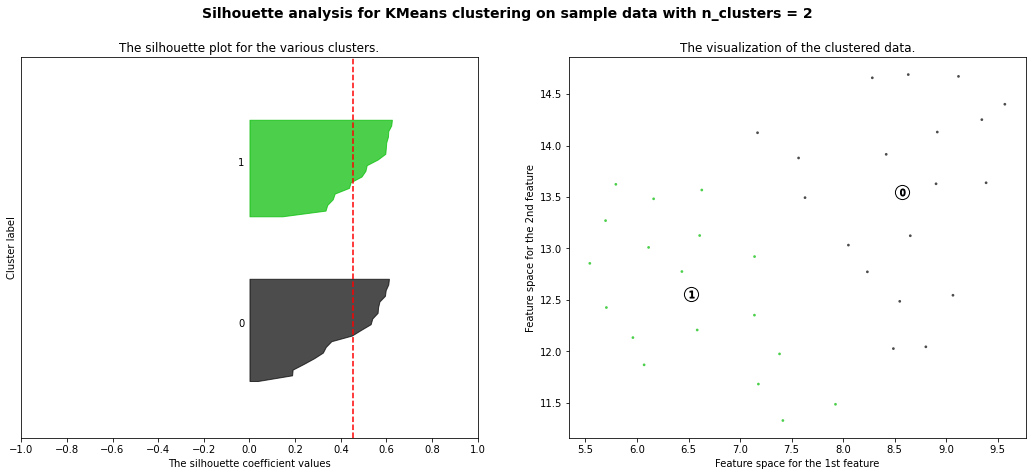

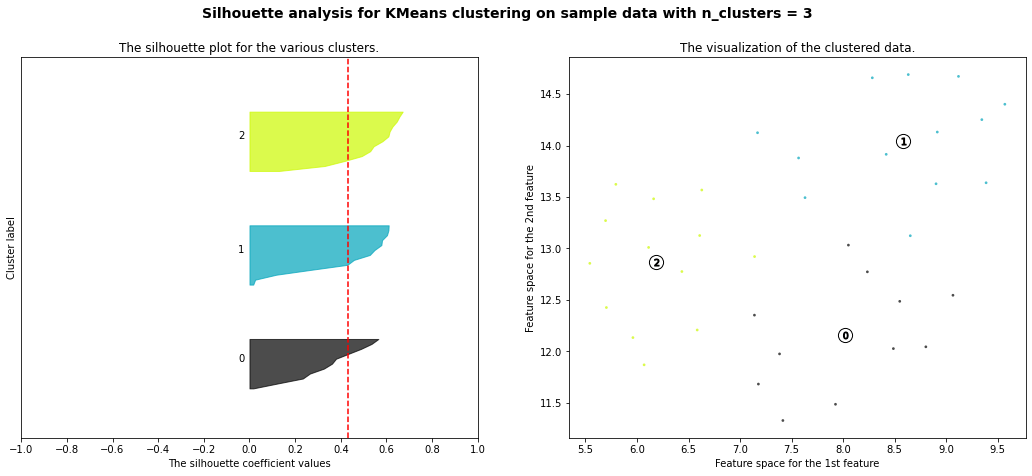

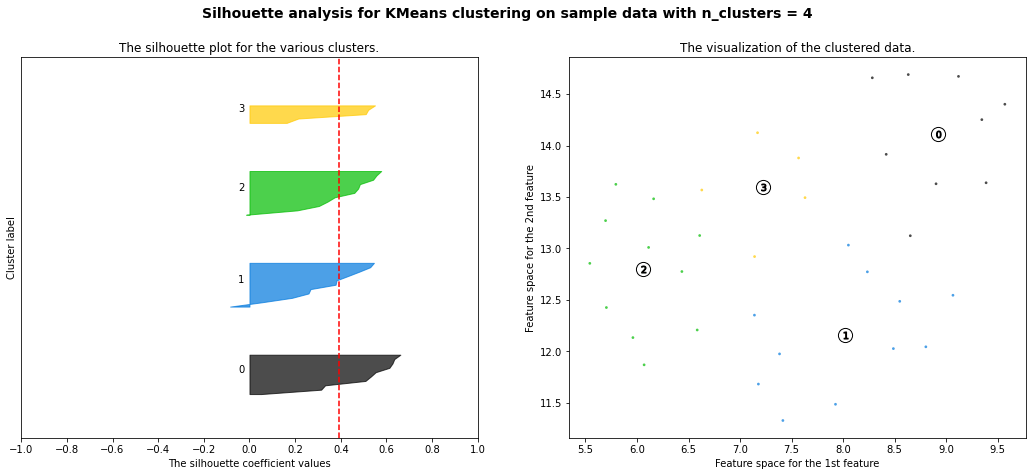

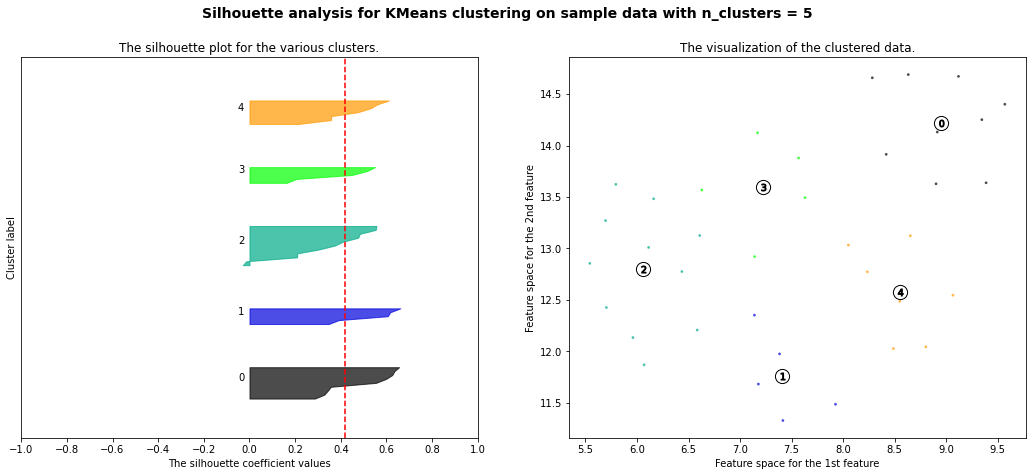

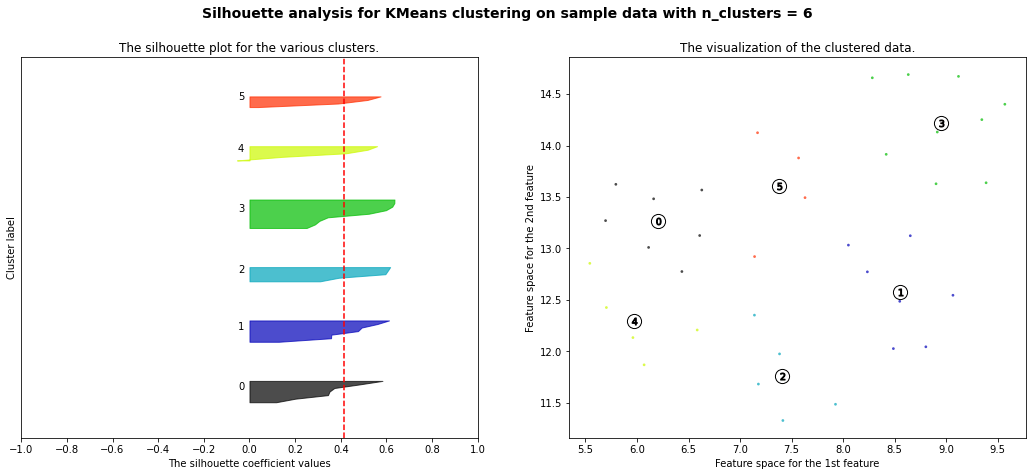

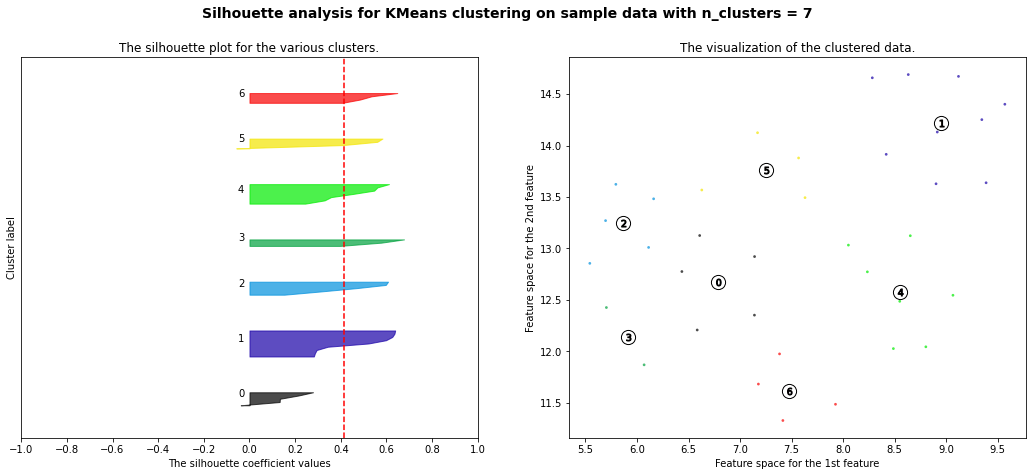

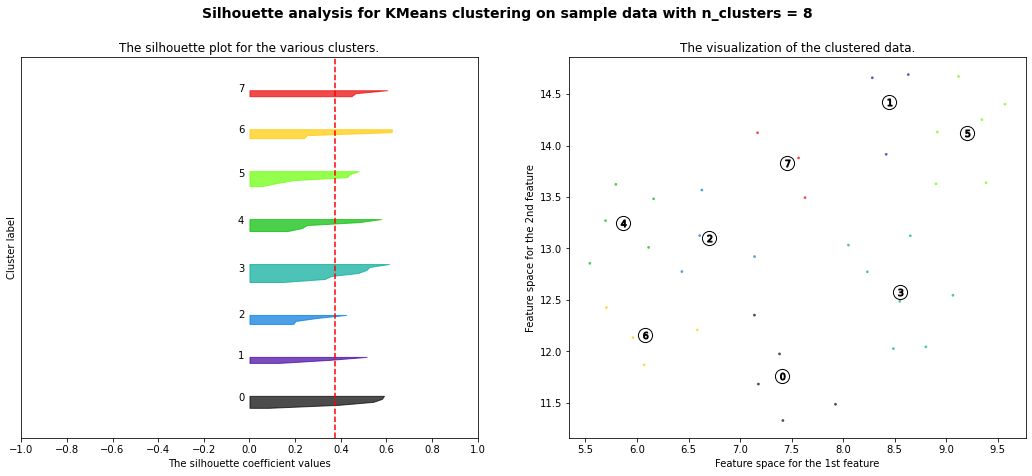

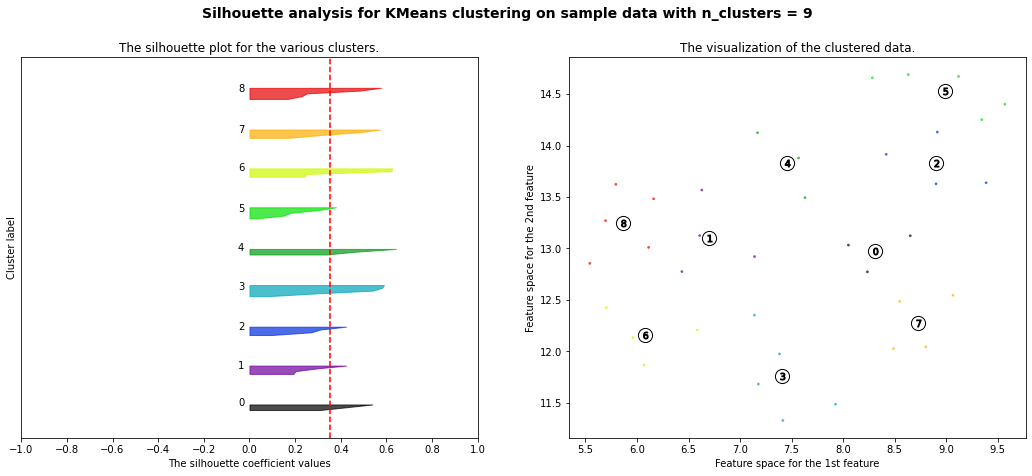

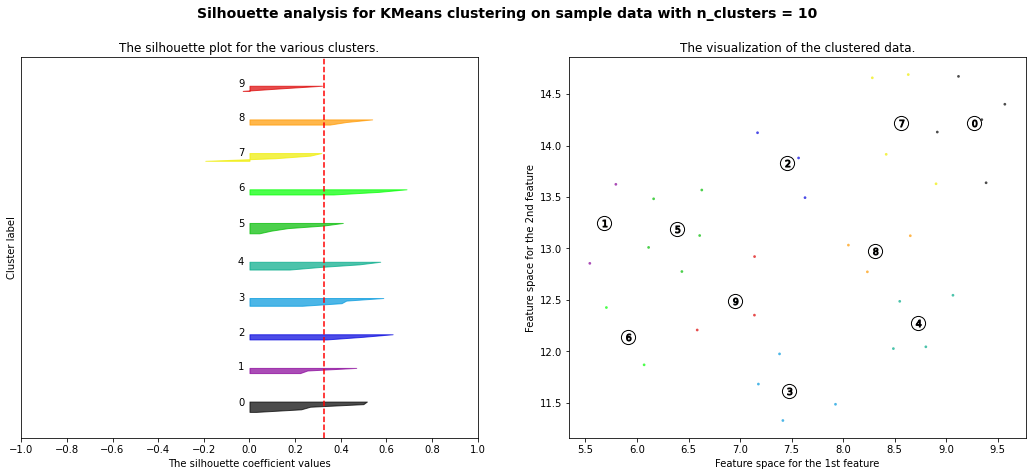

In [107]:
# umap
x_jungle_umap = apply_umap(x_jungle, 2)
# kmeans_clustering_elbow(x_jungle_umap, total_k = 30)
silhouette_analysis([2, 3, 4, 5, 6, 7, 8, 9, 10], x_jungle_umap)

### Mid

For n_clusters = 2 Average silhouette_score: 0.15589485130315126 , Calinski Harabasz score: 8.988713816919526 , Davies Bouldin: 1.9704152432766082
For n_clusters = 3 Average silhouette_score: 0.1716884182035881 , Calinski Harabasz score: 8.554620413659528 , Davies Bouldin: 1.697288931802295
For n_clusters = 4 Average silhouette_score: 0.1971308112613774 , Calinski Harabasz score: 8.45263776613959 , Davies Bouldin: 1.4082824182213491
For n_clusters = 5 Average silhouette_score: 0.16753265891510363 , Calinski Harabasz score: 7.352341431133875 , Davies Bouldin: 1.3349453969219924
For n_clusters = 6 Average silhouette_score: 0.19093834169872223 , Calinski Harabasz score: 7.269876511345634 , Davies Bouldin: 1.2989773083778147
For n_clusters = 7 Average silhouette_score: 0.16156259292949976 , Calinski Harabasz score: 7.242398086264446 , Davies Bouldin: 1.2714765400870862
For n_clusters = 8 Average silhouette_score: 0.1262443541710616 , Calinski Harabasz score: 6.78699818071635 , Davies Bould

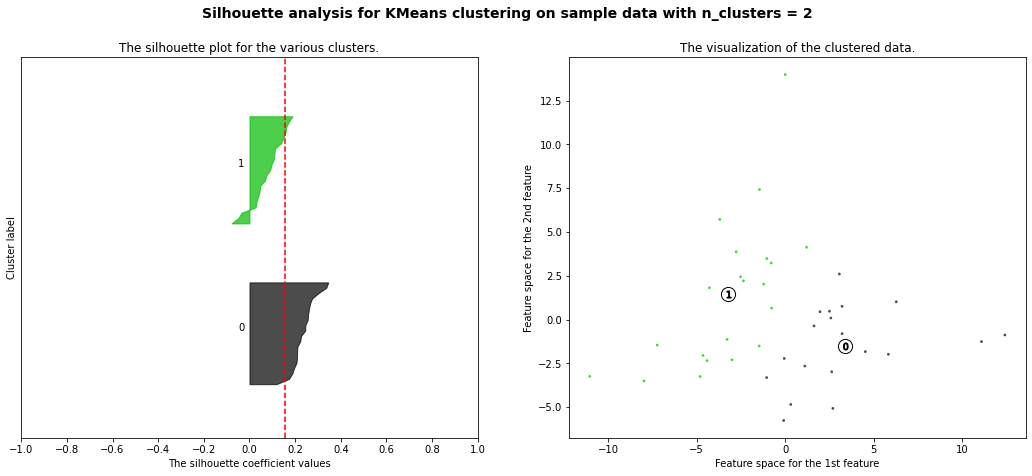

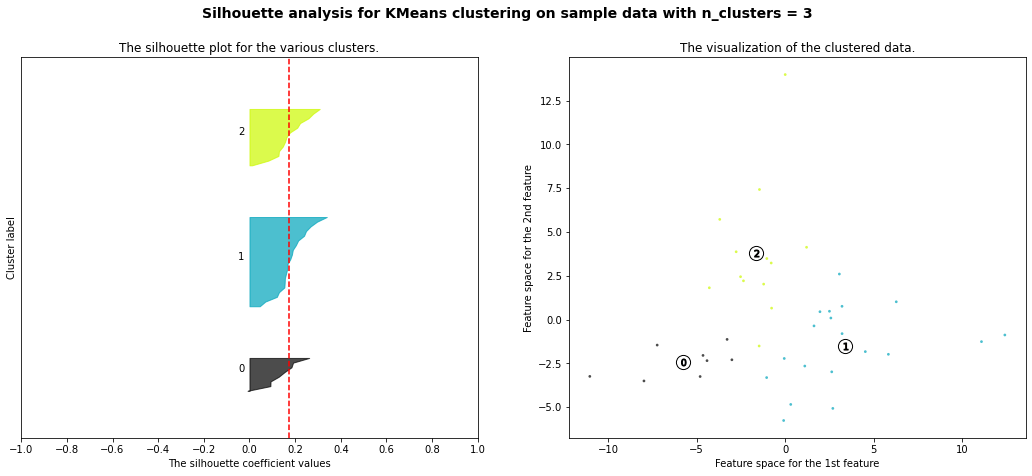

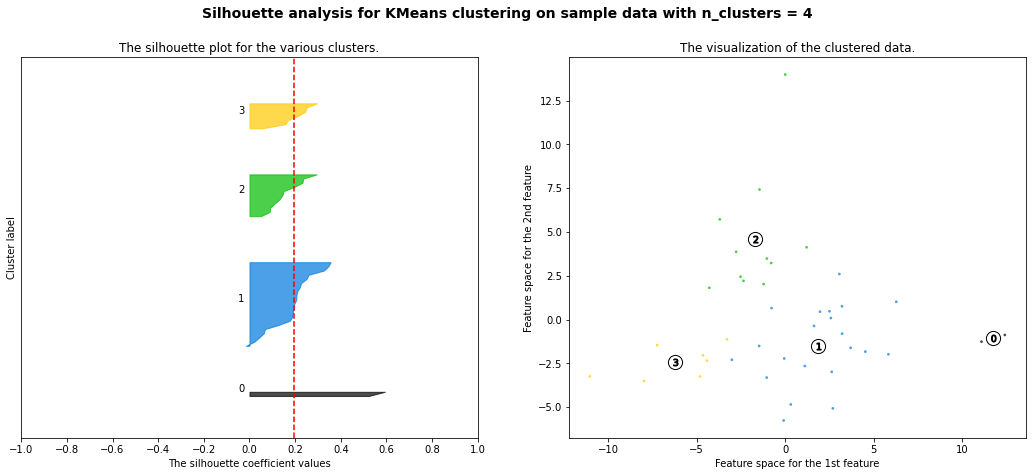

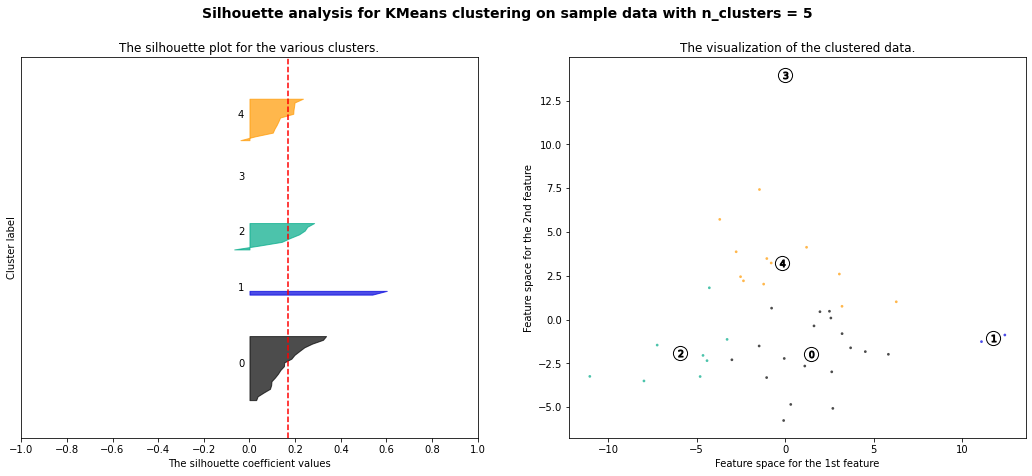

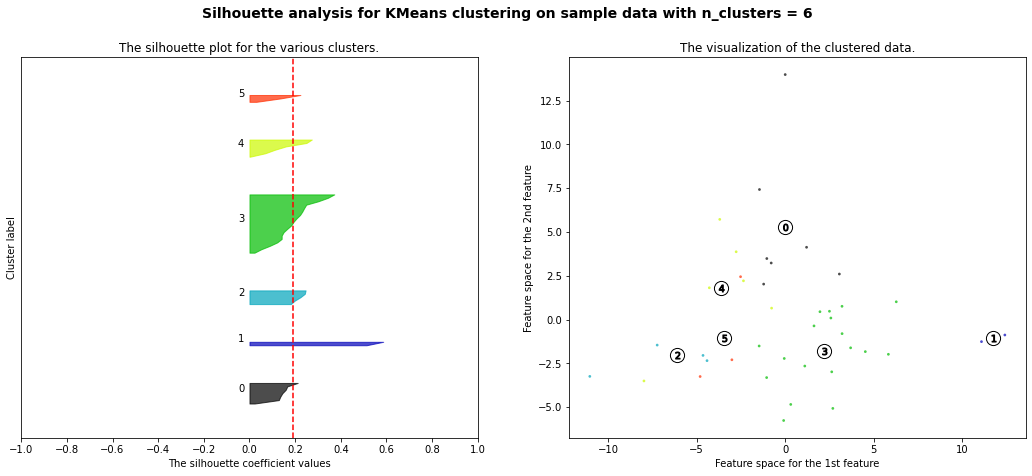

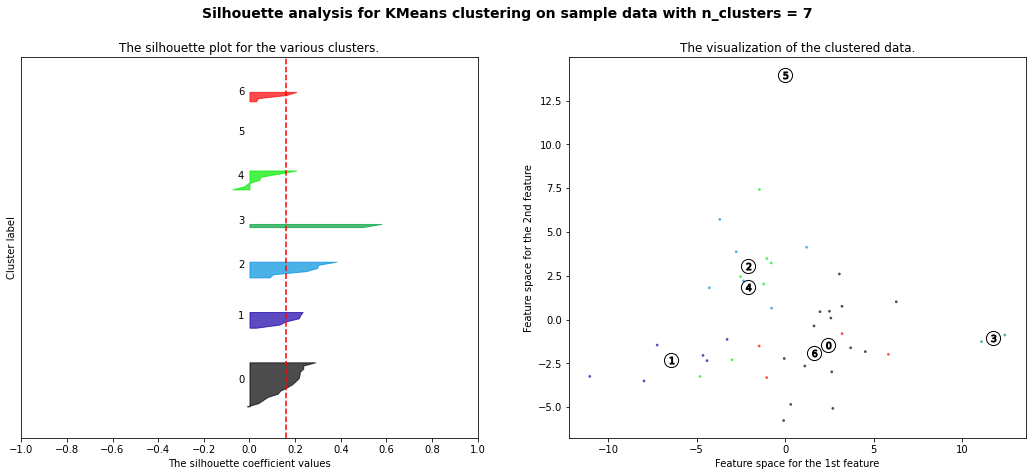

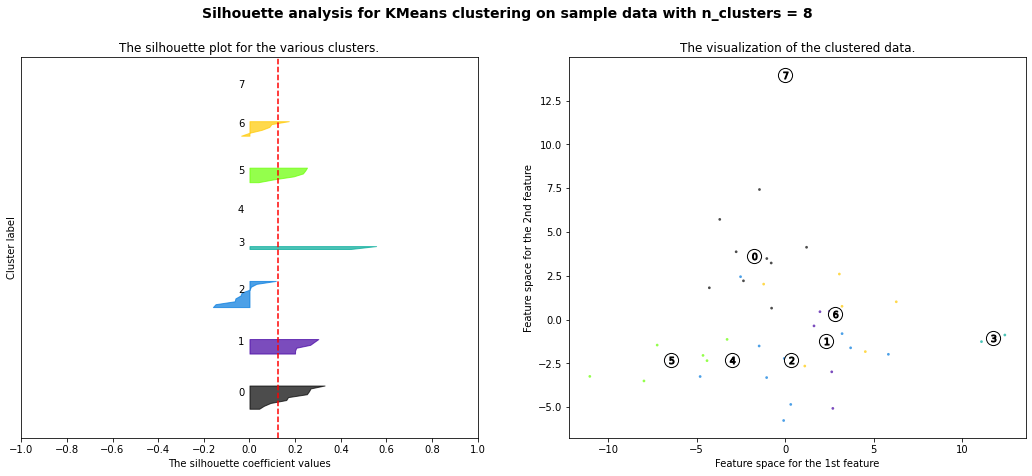

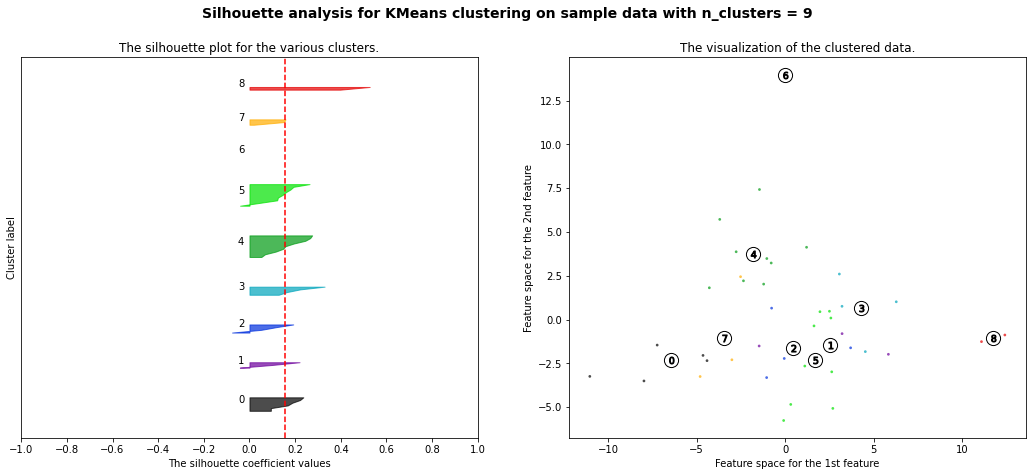

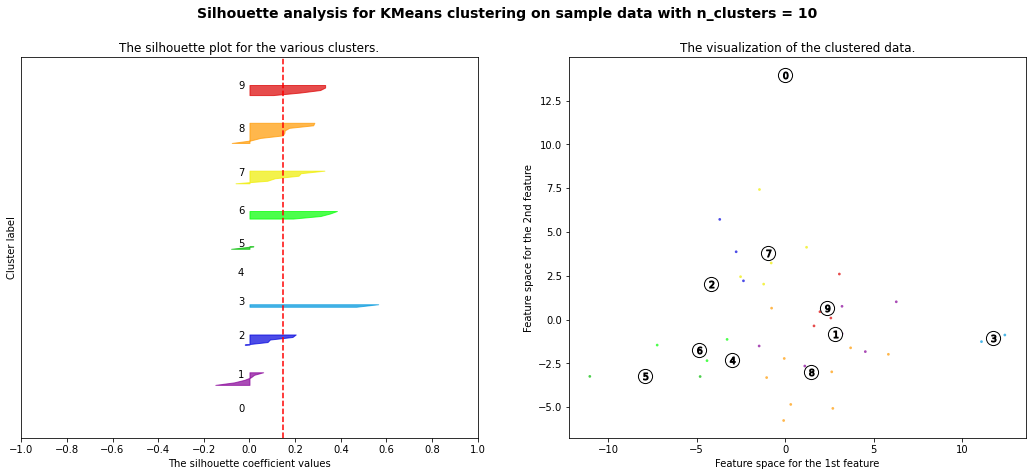

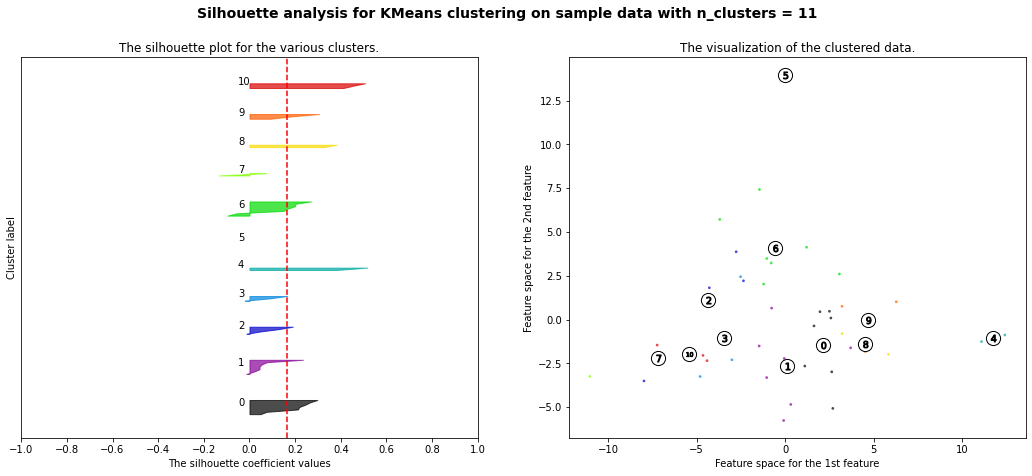

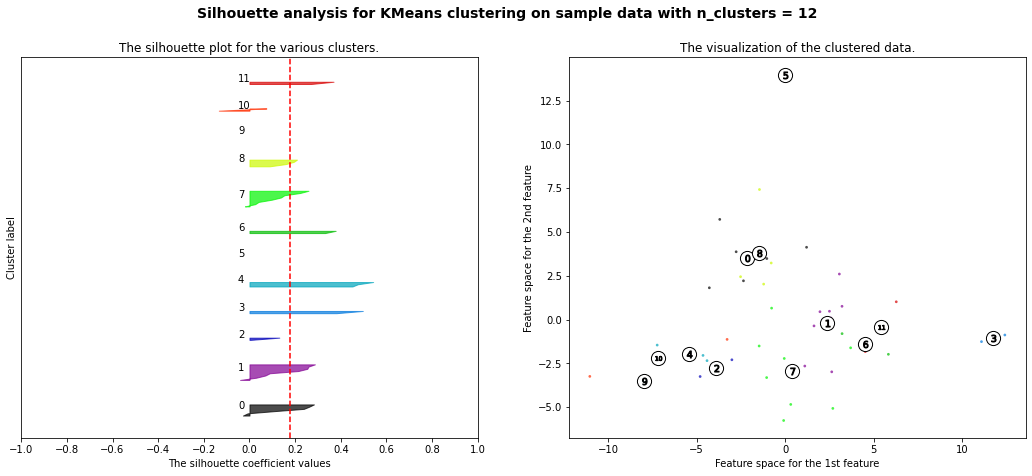

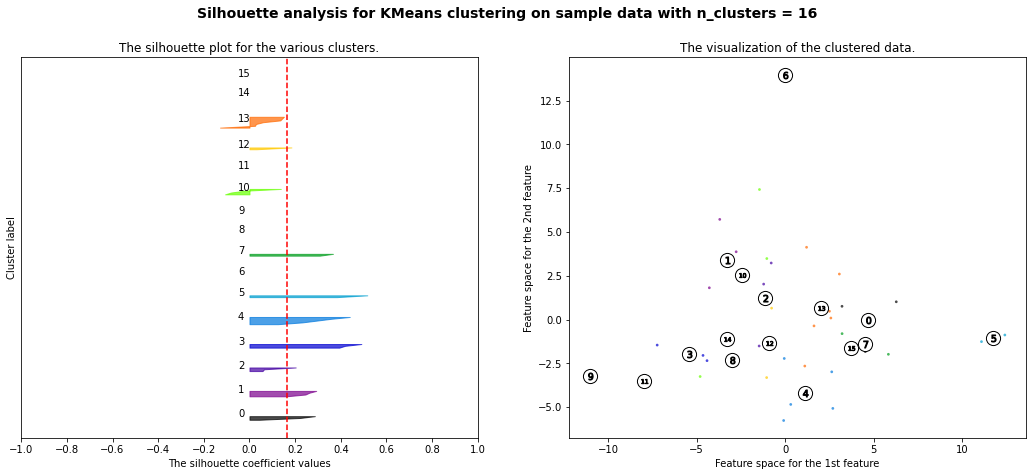

In [108]:
x_mid, y_mid = standarize_df(mid_soloq)
# pca
x_mid_pca = apply_pca(x_mid, 0.85)
# kmeans_clustering_elbow(x_mid_pca, total_k = 30)
silhouette_analysis([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 16], x_mid_pca)



For n_clusters = 2 Average silhouette_score: 0.45554212 , Calinski Harabasz score: 50.17518279368745 , Davies Bouldin: 0.8145305543008581
For n_clusters = 3 Average silhouette_score: 0.44541365 , Calinski Harabasz score: 48.319952344050485 , Davies Bouldin: 0.8147676468667466
For n_clusters = 4 Average silhouette_score: 0.39502382 , Calinski Harabasz score: 49.95001327345596 , Davies Bouldin: 0.8221809205517865
For n_clusters = 5 Average silhouette_score: 0.40910795 , Calinski Harabasz score: 49.13182259071624 , Davies Bouldin: 0.7413669446523313
For n_clusters = 6 Average silhouette_score: 0.39848635 , Calinski Harabasz score: 53.334253172491934 , Davies Bouldin: 0.7557062001393297
For n_clusters = 7 Average silhouette_score: 0.4203652 , Calinski Harabasz score: 59.5233233088008 , Davies Bouldin: 0.7043819502992144
For n_clusters = 8 Average silhouette_score: 0.4079263 , Calinski Harabasz score: 56.81945414333539 , Davies Bouldin: 0.6726230947940457
For n_clusters = 9 Average silhouet

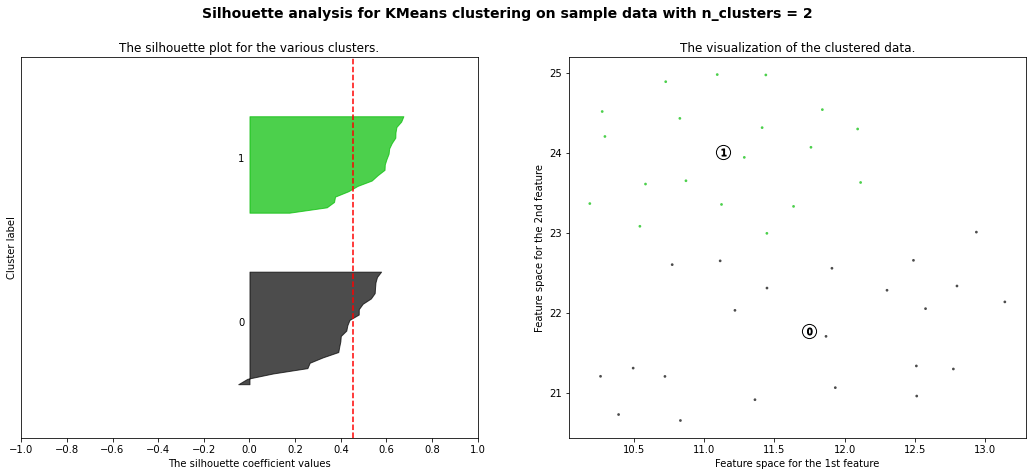

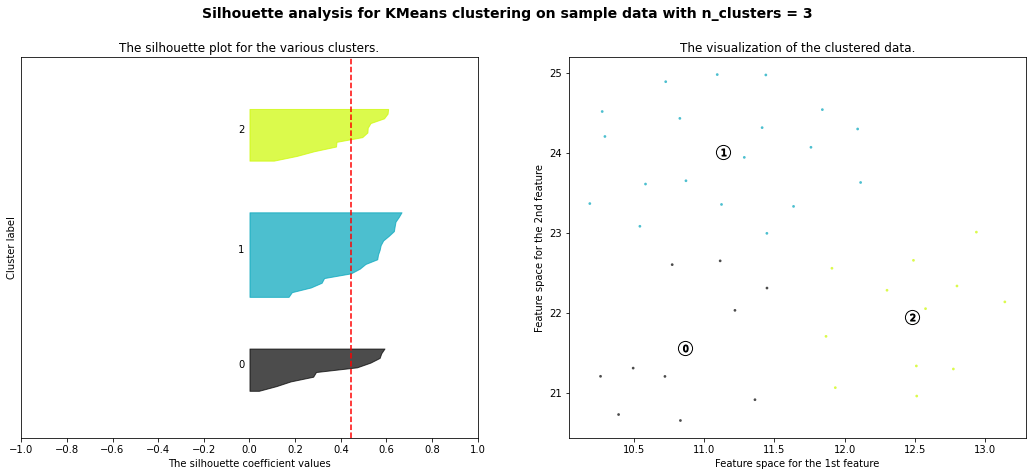

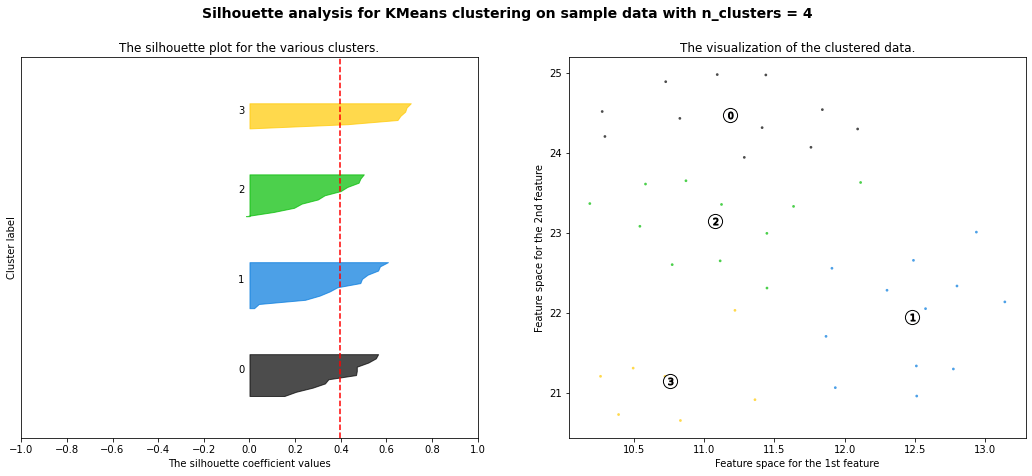

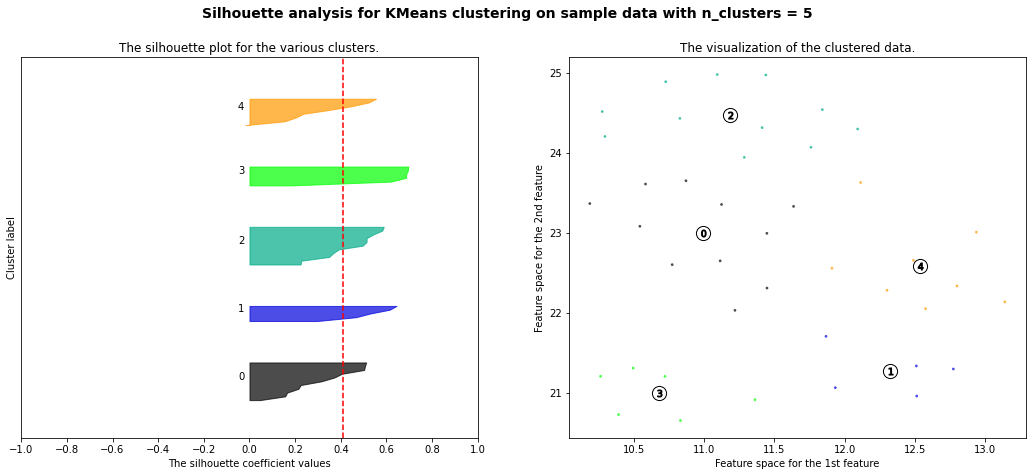

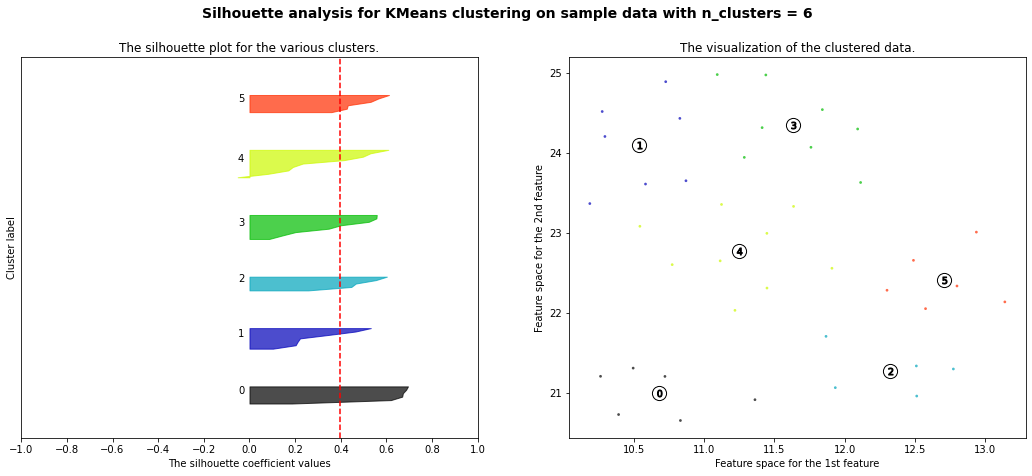

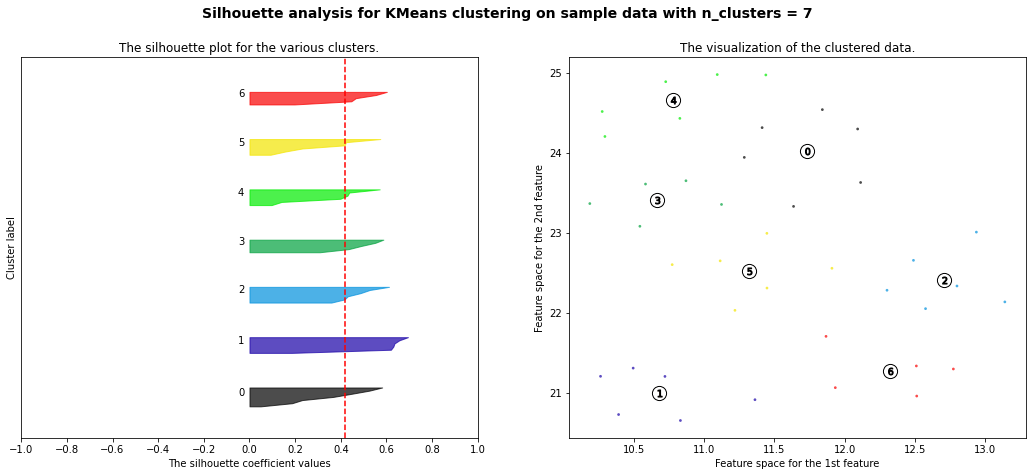

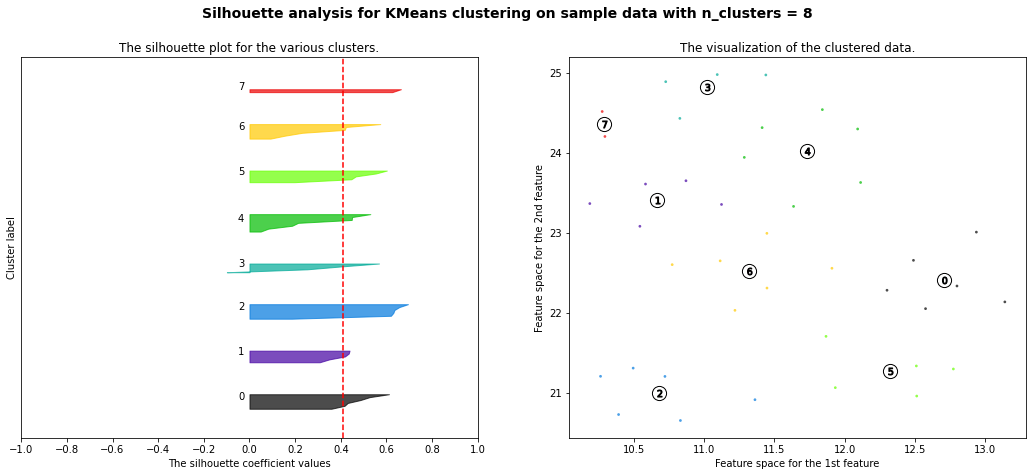

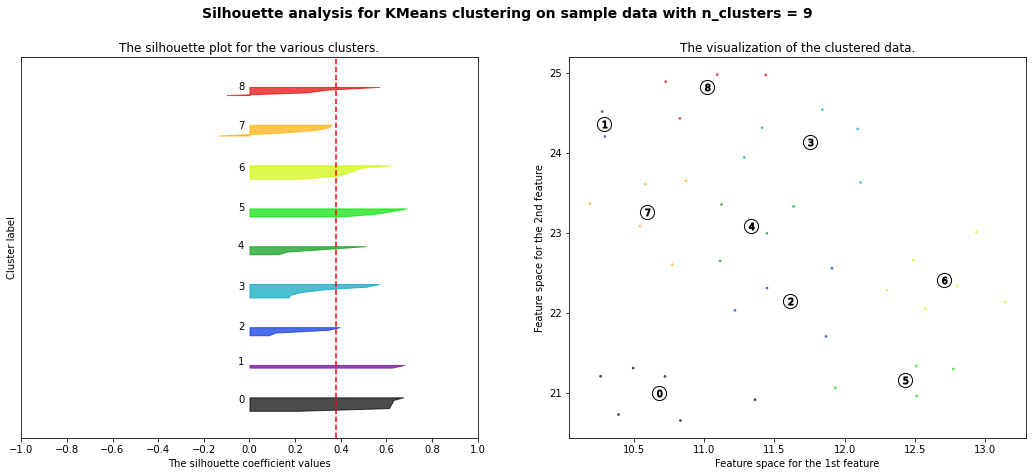

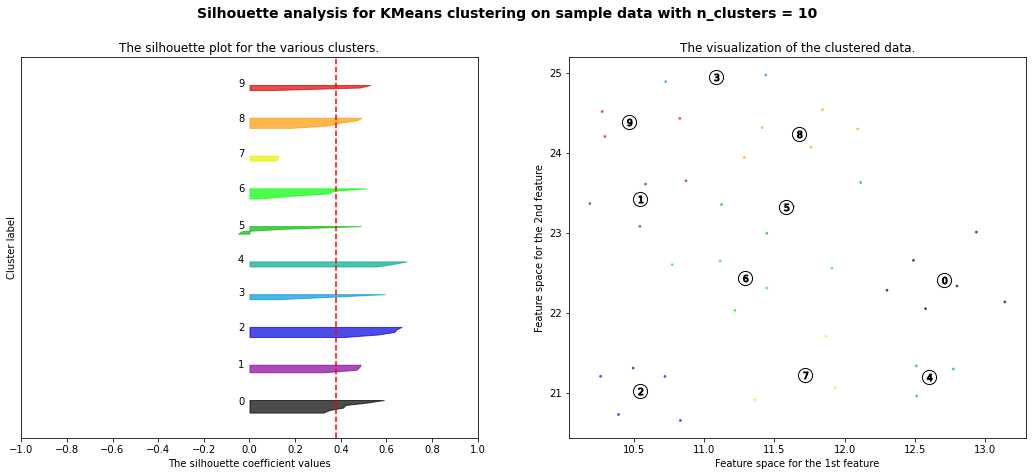

In [109]:
# umap
x_mid_umap = apply_umap(x_mid, 2)
# kmeans_clustering_elbow(x_mid_umap, total_k = 30)
silhouette_analysis([2, 3, 4, 5, 6, 7, 8, 9, 10], x_mid_umap)

### Bottom

For n_clusters = 2 Average silhouette_score: 0.27614049308316146 , Calinski Harabasz score: 5.11508633628164 , Davies Bouldin: 1.6294792307570973
For n_clusters = 3 Average silhouette_score: 0.29239314833129915 , Calinski Harabasz score: 4.756456918566982 , Davies Bouldin: 1.1091966400782989
For n_clusters = 4 Average silhouette_score: 0.14913994236982295 , Calinski Harabasz score: 4.871422398462015 , Davies Bouldin: 1.2898745810340708
For n_clusters = 5 Average silhouette_score: 0.12320725458587412 , Calinski Harabasz score: 5.255833607612724 , Davies Bouldin: 1.0397253265206565
For n_clusters = 6 Average silhouette_score: 0.16118937985731982 , Calinski Harabasz score: 5.631725798478382 , Davies Bouldin: 0.9449388423511014
For n_clusters = 7 Average silhouette_score: 0.09853123638195349 , Calinski Harabasz score: 5.310354760937193 , Davies Bouldin: 1.0852021662860305
For n_clusters = 8 Average silhouette_score: 0.13438916155265349 , Calinski Harabasz score: 5.967145033106622 , Davies 

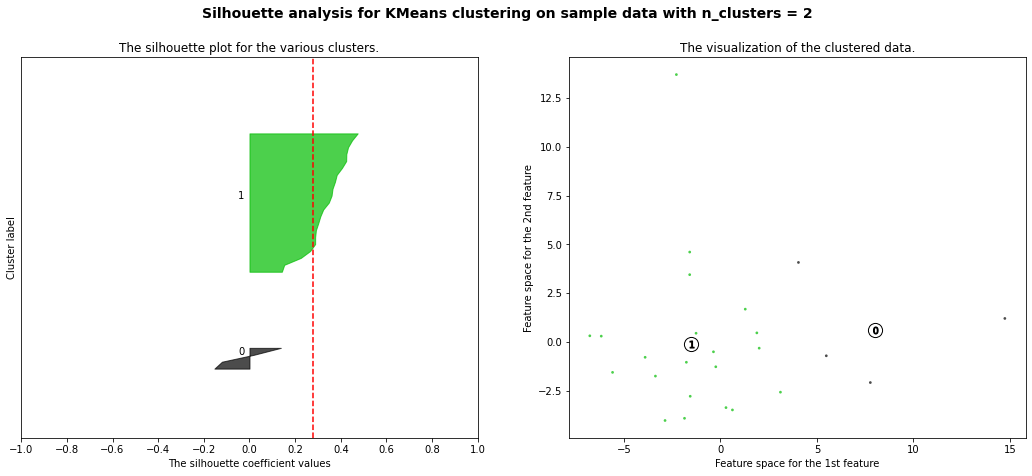

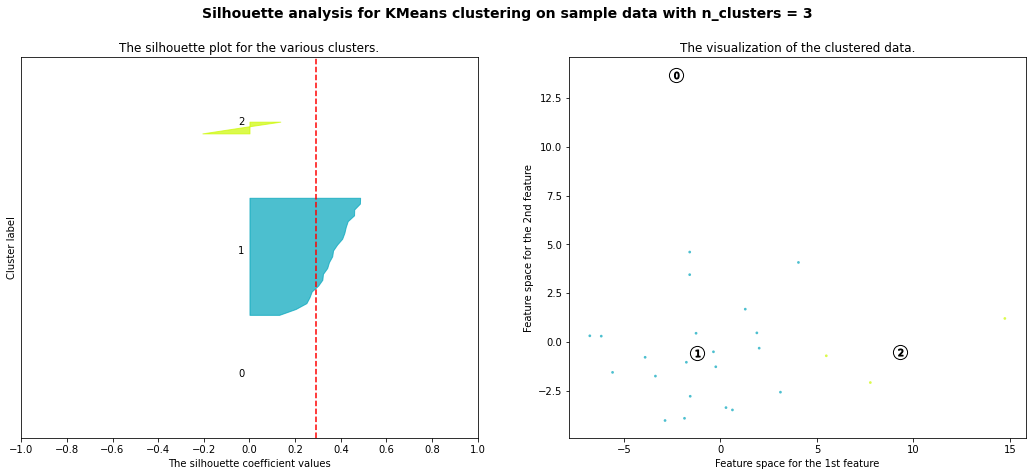

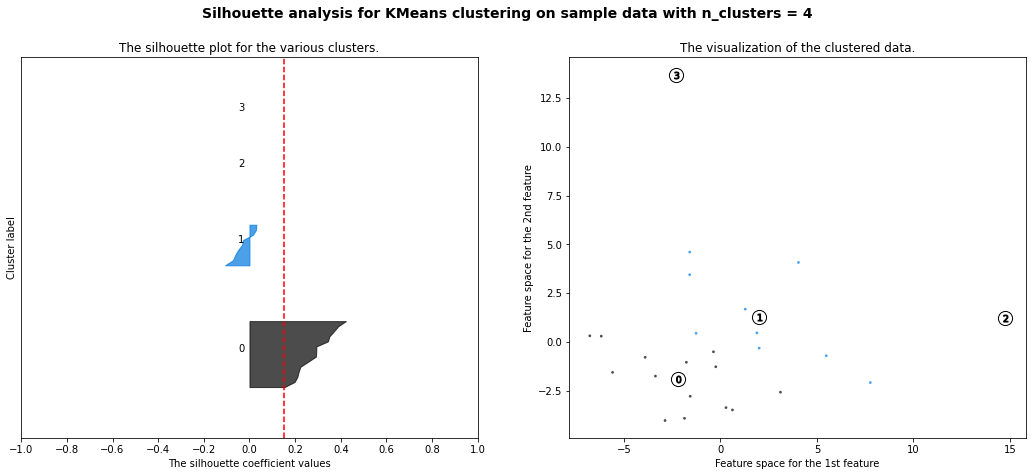

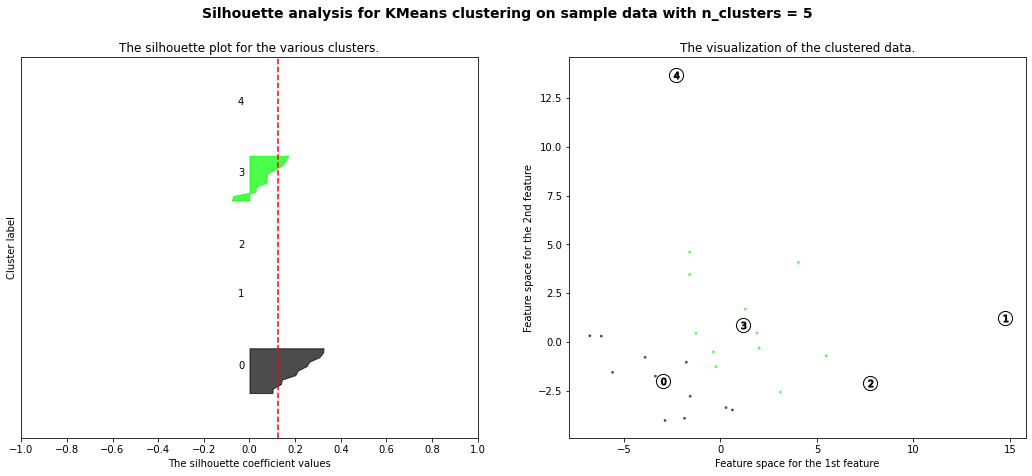

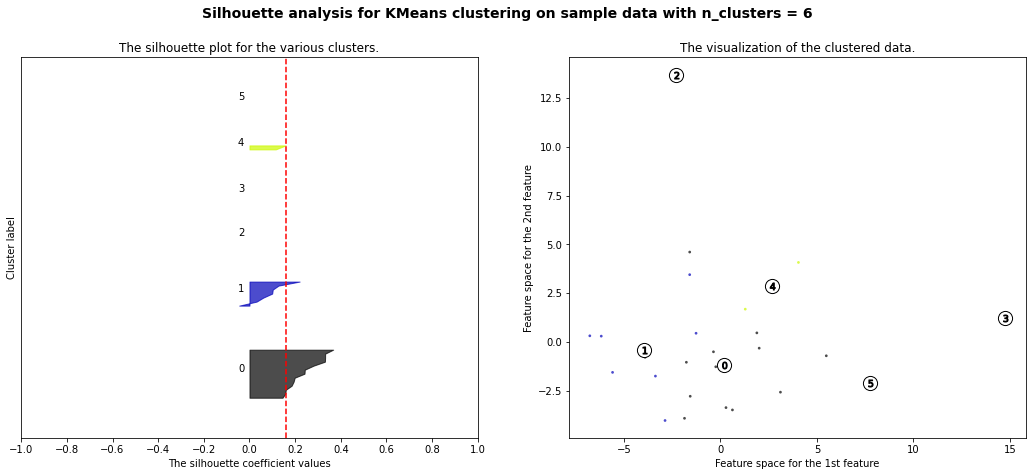

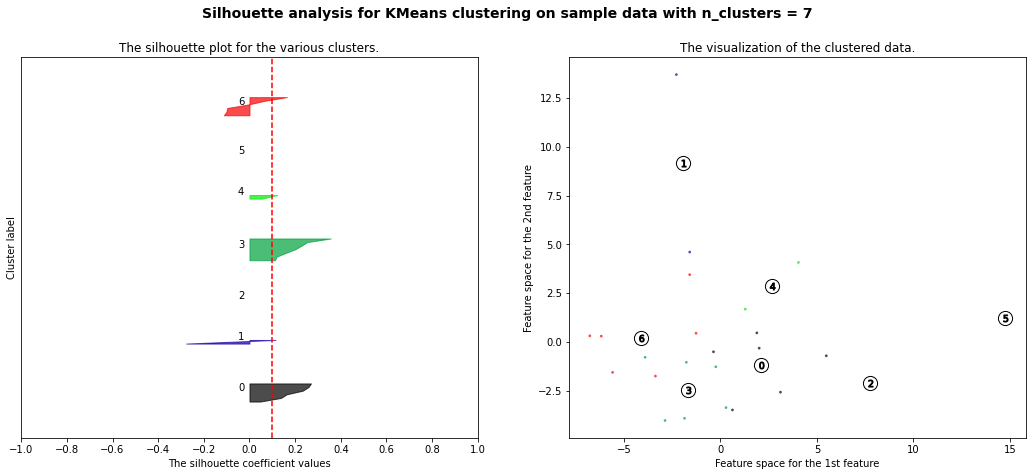

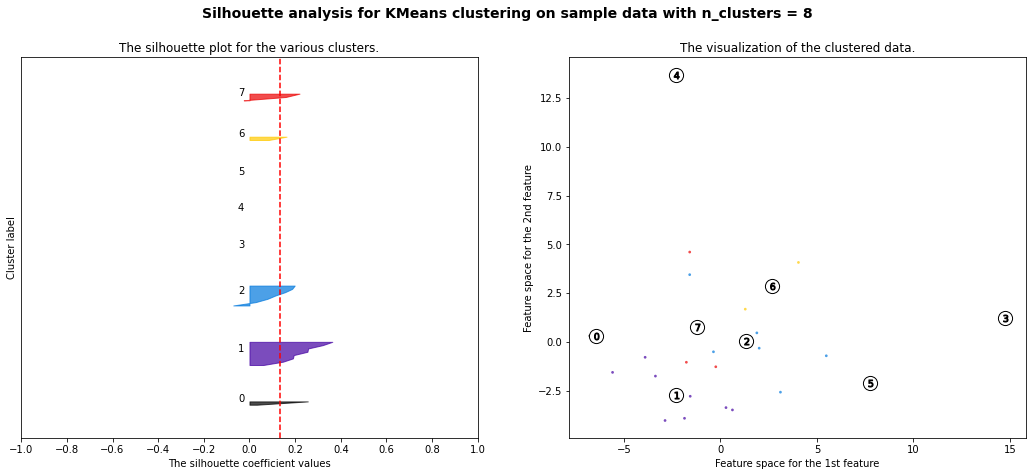

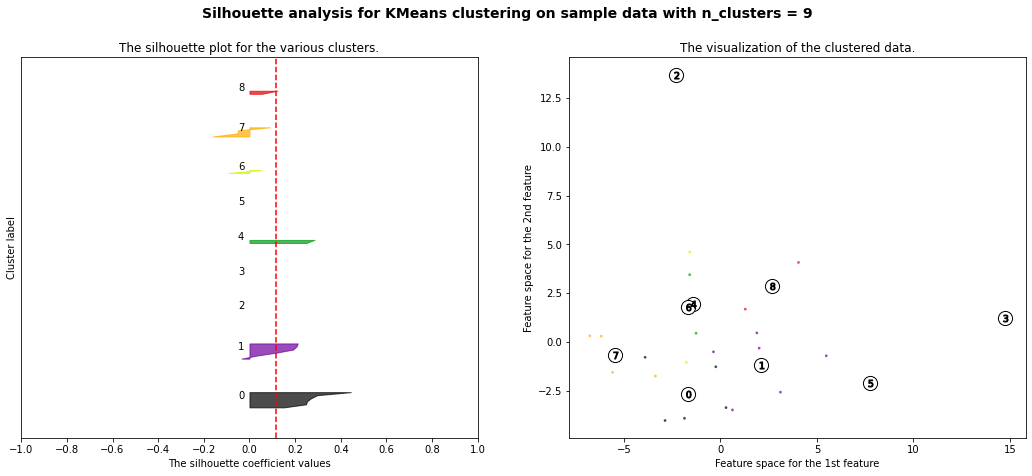

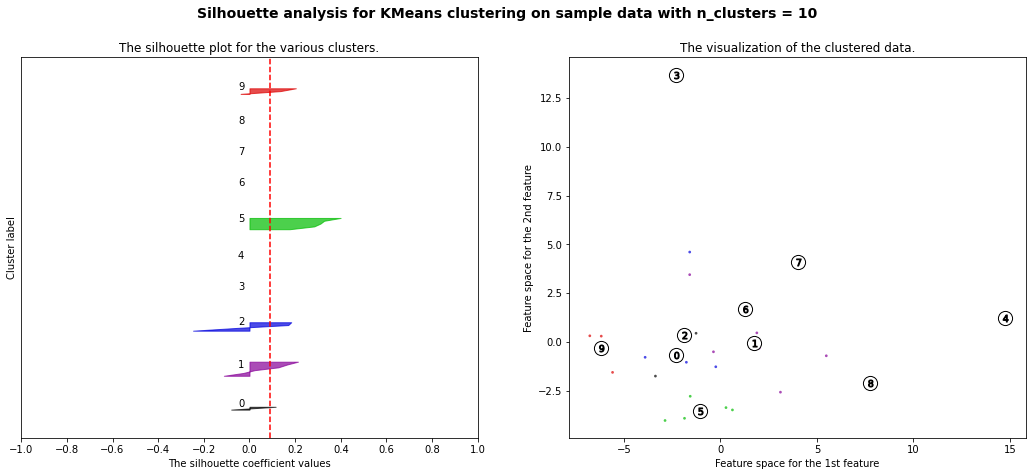

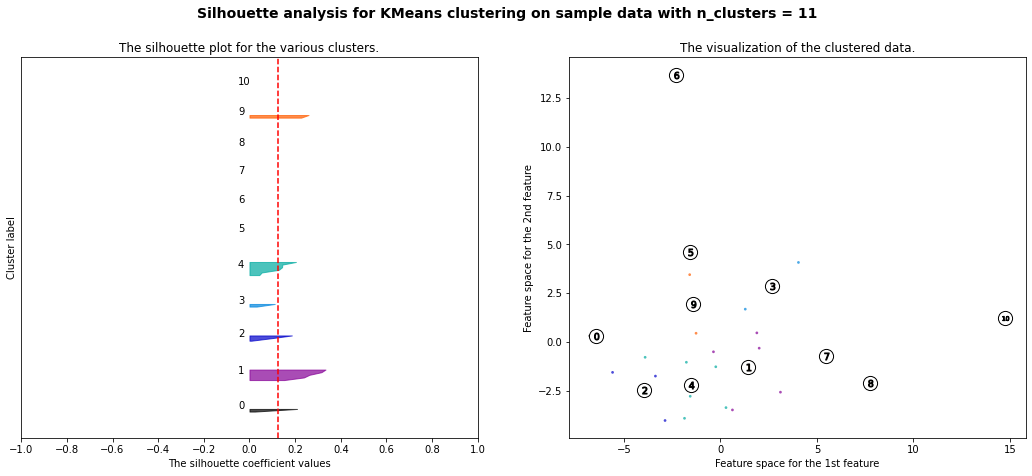

In [110]:
x_bottom, y_bottom = standarize_df(bottom_soloq)
# pca
x_bottom_pca = apply_pca(x_bottom, 0.85)
# kmeans_clustering_elbow(x_bottom_pca, total_k = 15)
silhouette_analysis([2, 3, 4, 5, 6, 7, 8, 9, 10, 11], x_bottom_pca)

For n_clusters = 2 Average silhouette_score: 0.3934571 , Calinski Harabasz score: 22.89686352044662 , Davies Bouldin: 0.9256566082526745
For n_clusters = 3 Average silhouette_score: 0.35574296 , Calinski Harabasz score: 21.366372840424553 , Davies Bouldin: 0.8466221611141799
For n_clusters = 4 Average silhouette_score: 0.3396386 , Calinski Harabasz score: 23.325073952947996 , Davies Bouldin: 0.8452439822754304
For n_clusters = 5 Average silhouette_score: 0.3408914 , Calinski Harabasz score: 22.50445457702651 , Davies Bouldin: 0.7889467685425492
For n_clusters = 6 Average silhouette_score: 0.30430838 , Calinski Harabasz score: 22.639784107494677 , Davies Bouldin: 0.7634395973558977
For n_clusters = 7 Average silhouette_score: 0.31675386 , Calinski Harabasz score: 23.72479195209577 , Davies Bouldin: 0.7595640712002542


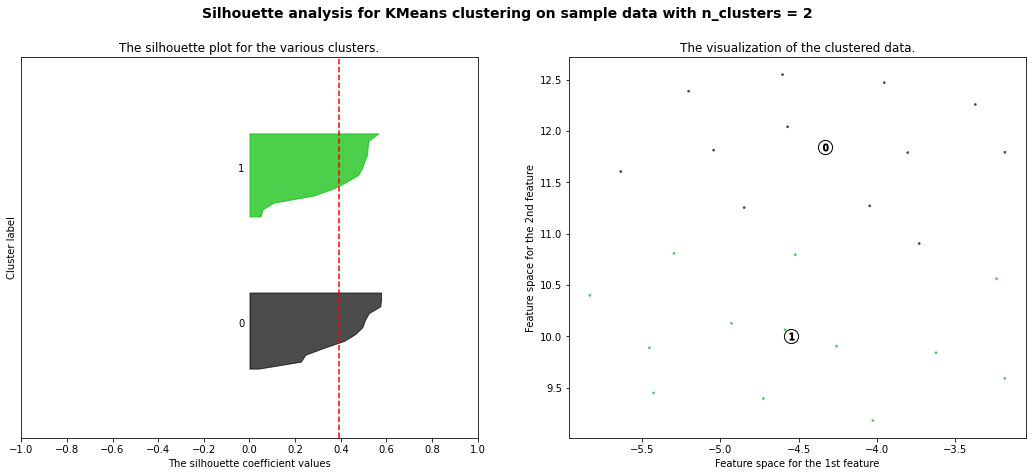

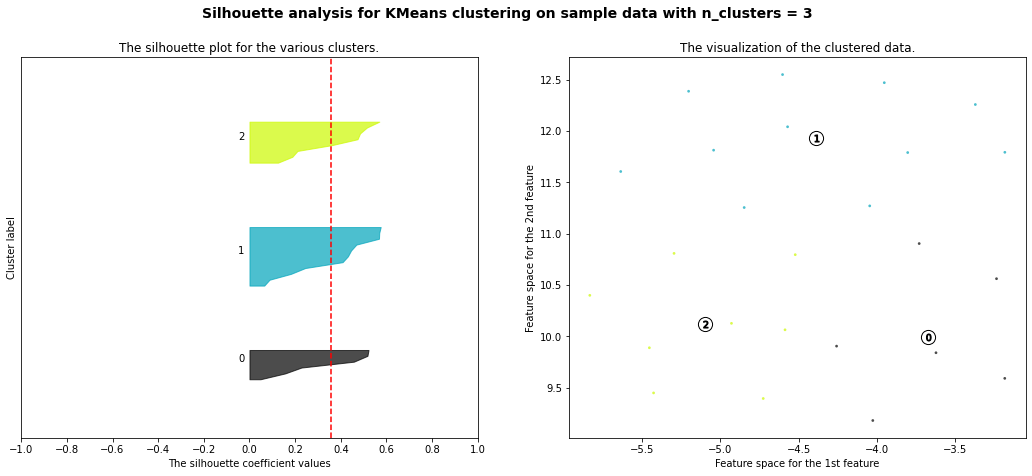

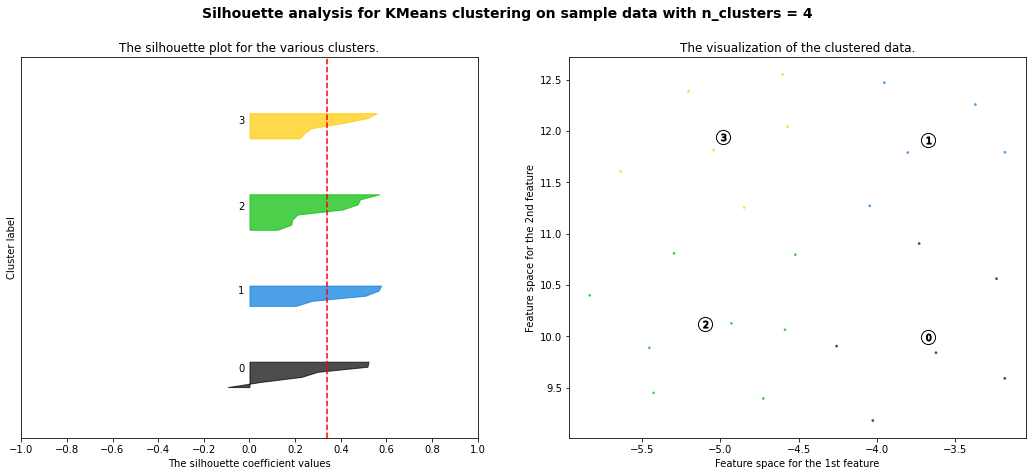

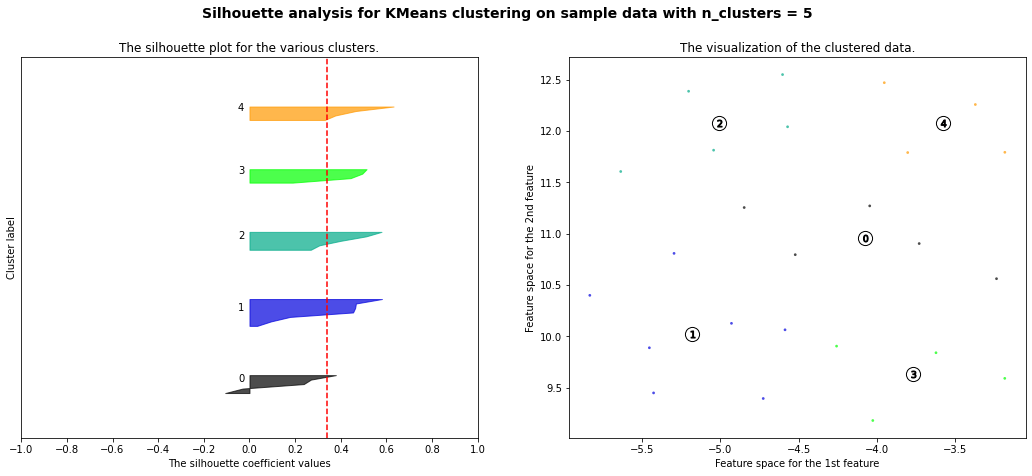

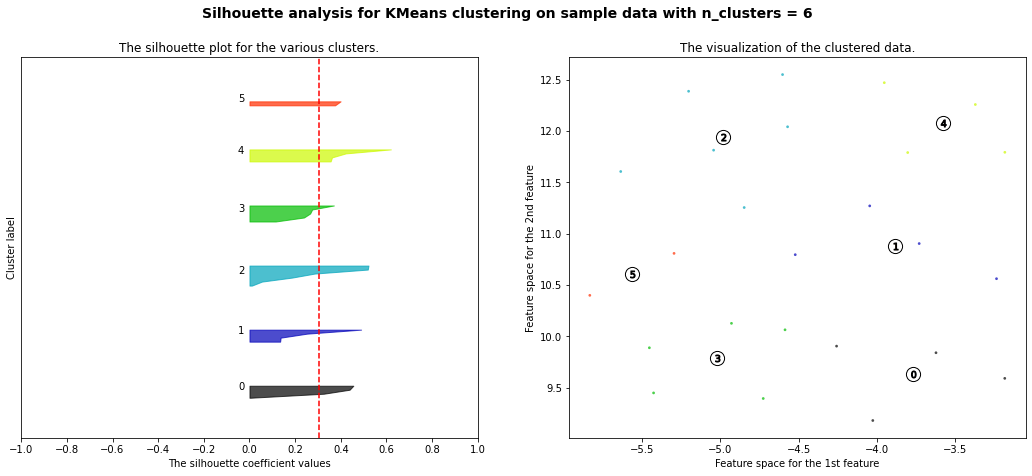

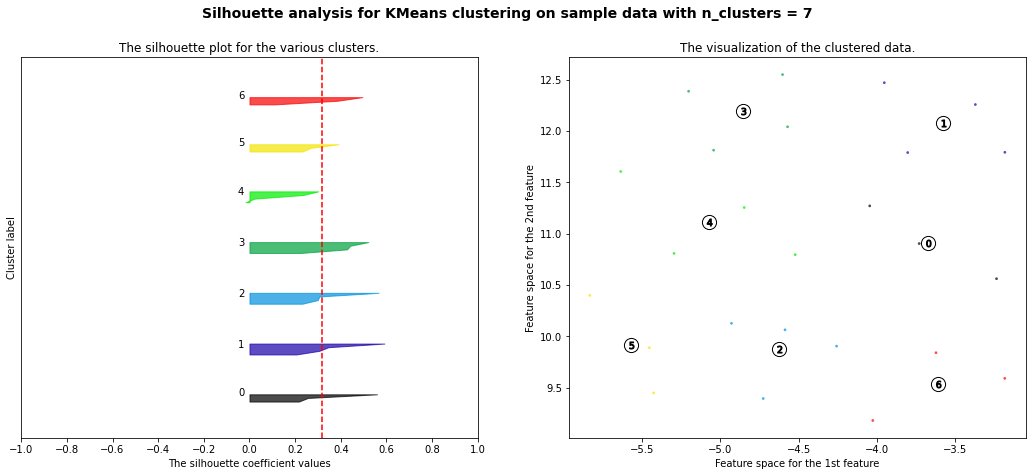

In [111]:
# umap
x_bottom_umap = apply_umap(x_bottom, 2)
# kmeans_clustering_elbow(x_bottom_umap, total_k = 15)
silhouette_analysis([2, 3, 4, 5, 6, 7], x_bottom_umap)

### Utility

For n_clusters = 2 Average silhouette_score: 0.24206954318101653 , Calinski Harabasz score: 9.465270005966891 , Davies Bouldin: 1.5007255462806715
For n_clusters = 3 Average silhouette_score: 0.2546158284266285 , Calinski Harabasz score: 10.659949304070697 , Davies Bouldin: 1.32751993757523
For n_clusters = 4 Average silhouette_score: 0.26437461650497274 , Calinski Harabasz score: 10.093831206484609 , Davies Bouldin: 1.077370896089647
For n_clusters = 5 Average silhouette_score: 0.2736442186151428 , Calinski Harabasz score: 10.541093870918589 , Davies Bouldin: 0.8867442299181267
For n_clusters = 6 Average silhouette_score: 0.22493918516892514 , Calinski Harabasz score: 10.785311270106567 , Davies Bouldin: 0.9455795500609567
For n_clusters = 7 Average silhouette_score: 0.21072296321399225 , Calinski Harabasz score: 10.006542936981255 , Davies Bouldin: 0.8348612735478161
For n_clusters = 8 Average silhouette_score: 0.1775110053373288 , Calinski Harabasz score: 9.966303009727547 , Davies 

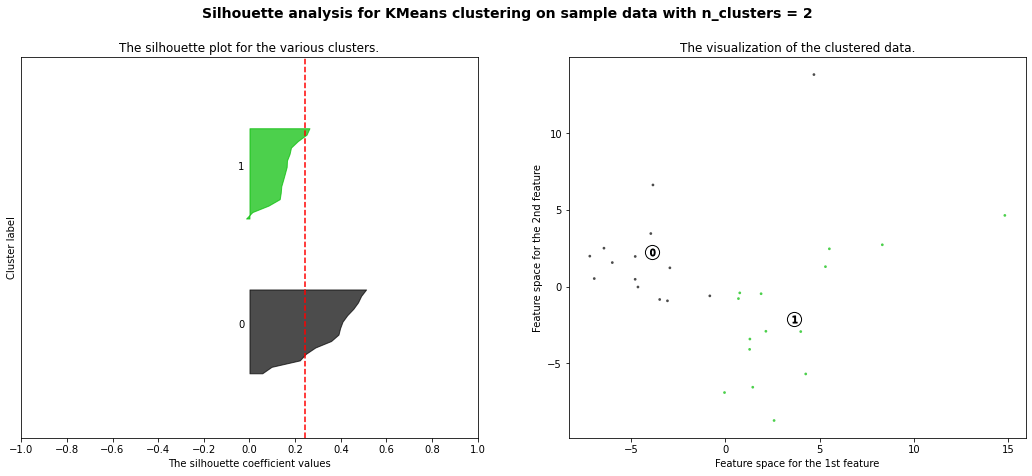

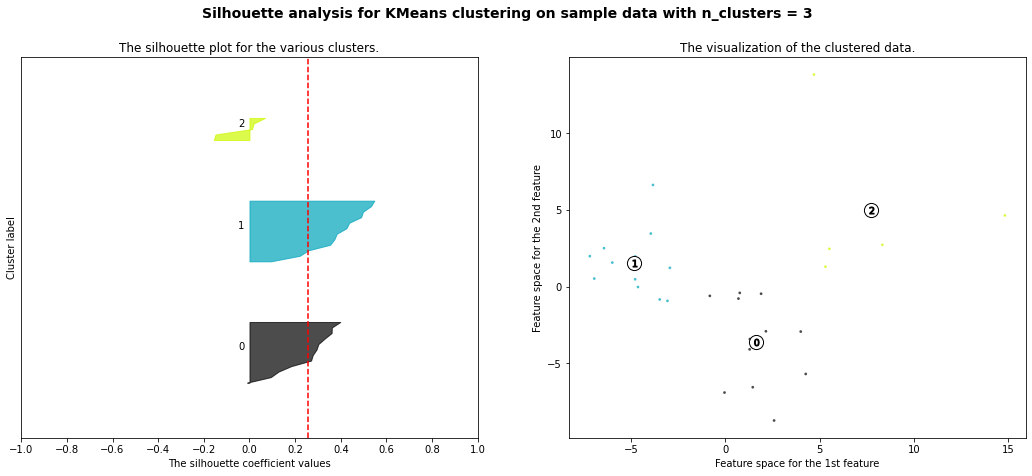

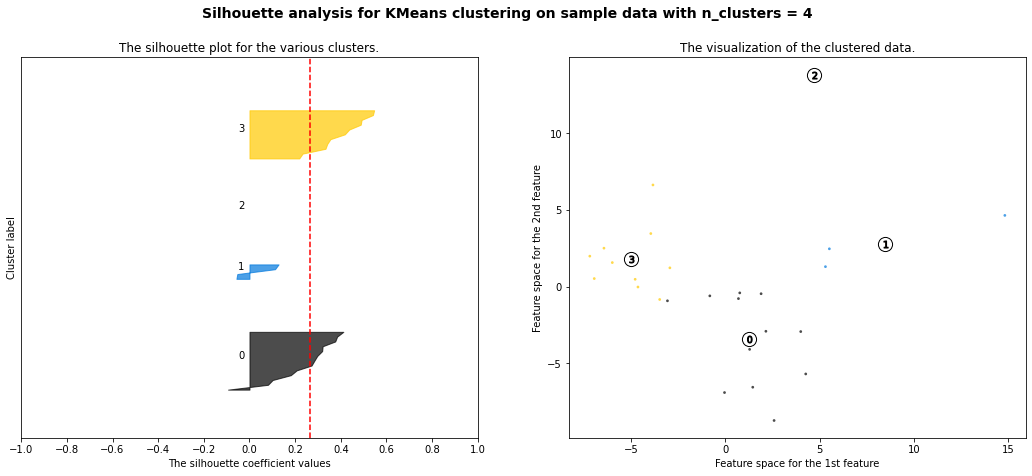

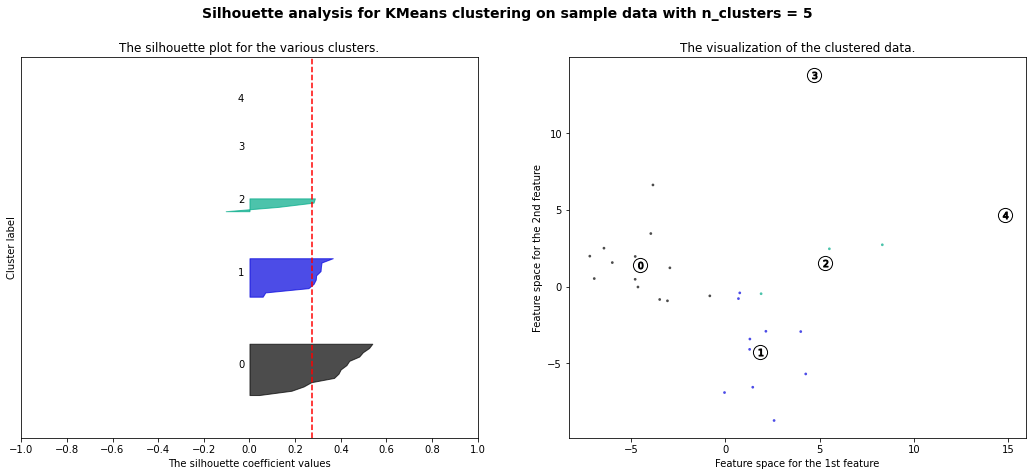

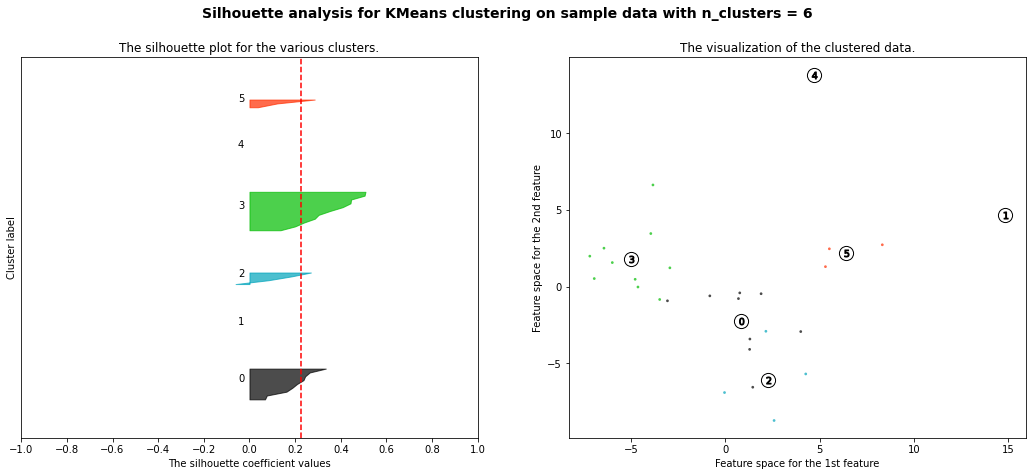

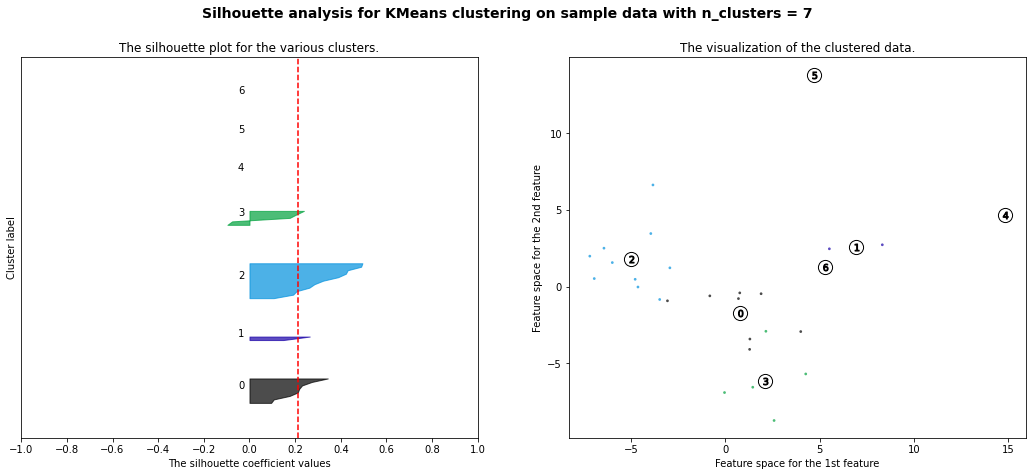

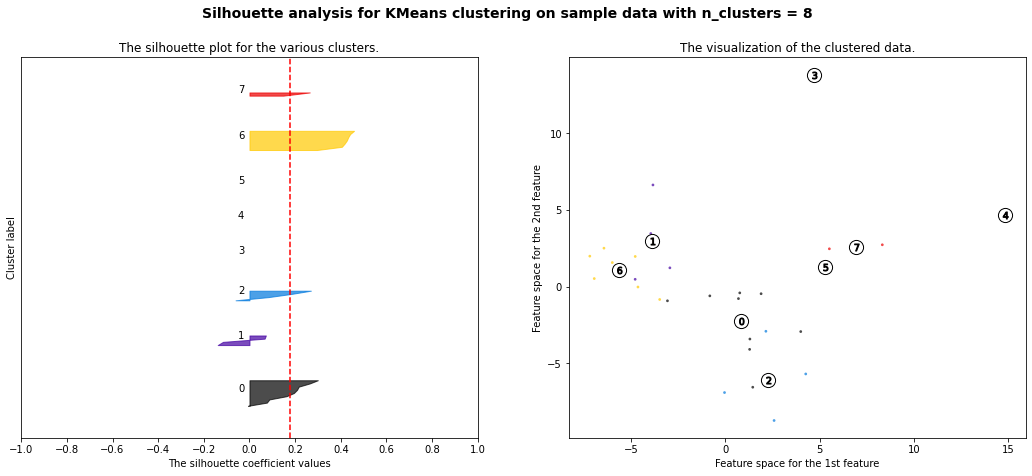

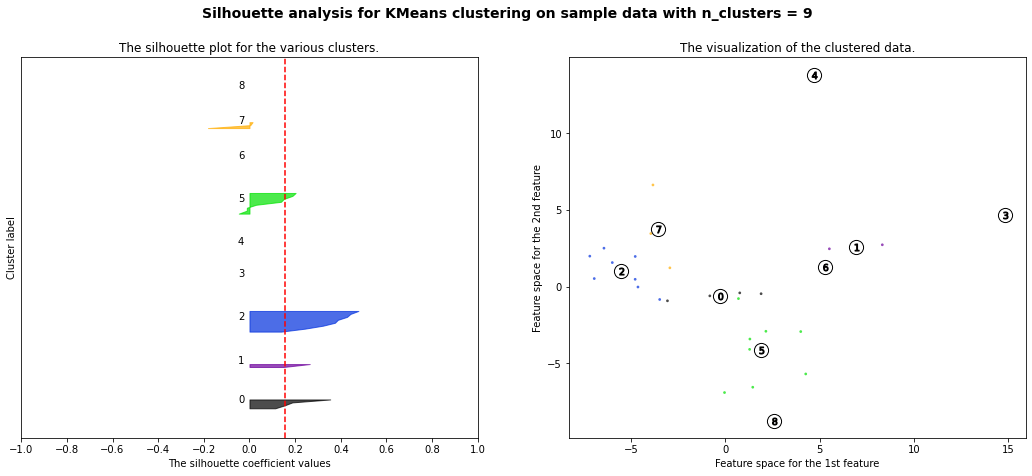

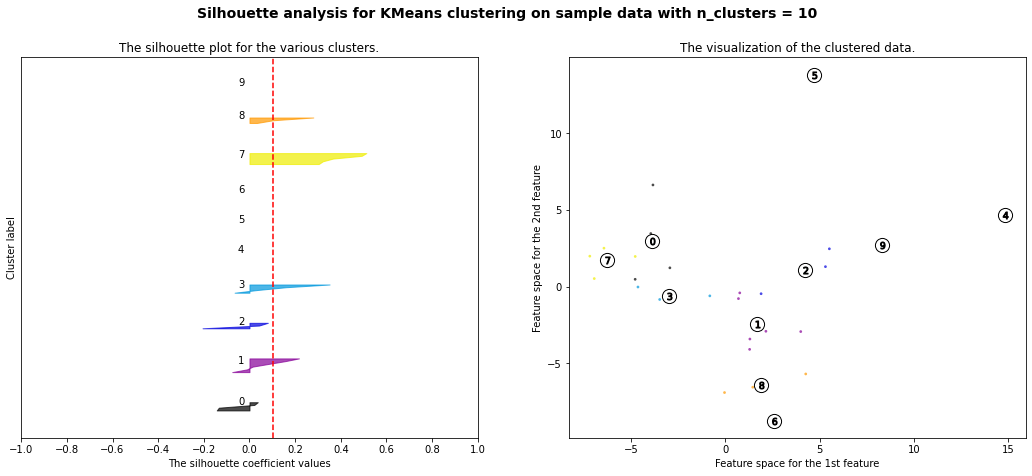

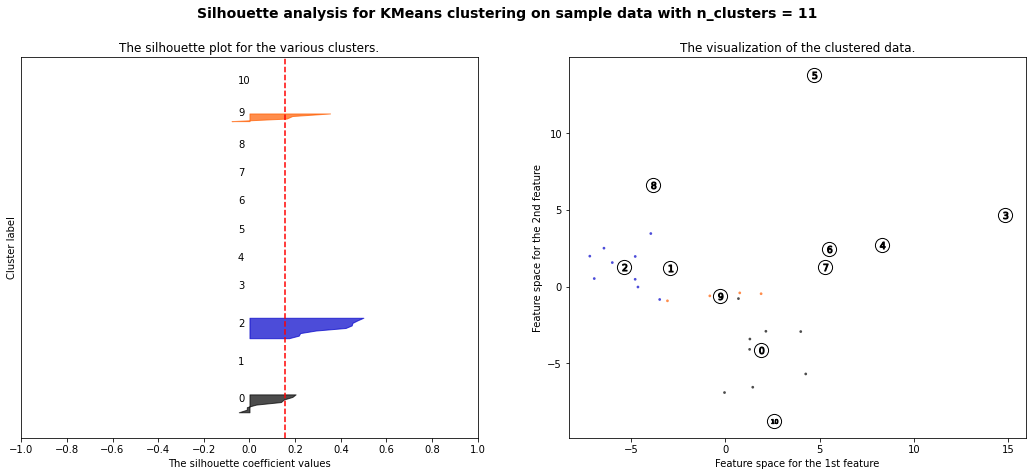

In [112]:
x_utility, y_utility = standarize_df(utility_soloq)
# pca
x_utility_pca = apply_pca(x_utility, 0.85)
# kmeans_clustering_elbow(x_utility_pca, total_k = 15)
silhouette_analysis([2, 3, 4, 5, 6, 7, 8, 9, 10, 11], x_utility_pca)

For n_clusters = 2 Average silhouette_score: 0.54295397 , Calinski Harabasz score: 57.75508163220293 , Davies Bouldin: 0.6242452703293133
For n_clusters = 3 Average silhouette_score: 0.4419832 , Calinski Harabasz score: 47.03139896962277 , Davies Bouldin: 0.8279734498100907
For n_clusters = 4 Average silhouette_score: 0.4260011 , Calinski Harabasz score: 51.99892501332194 , Davies Bouldin: 0.7431955247722657
For n_clusters = 5 Average silhouette_score: 0.33882713 , Calinski Harabasz score: 44.55499495886471 , Davies Bouldin: 0.8311507711153403
For n_clusters = 6 Average silhouette_score: 0.3500822 , Calinski Harabasz score: 45.11288057744585 , Davies Bouldin: 0.8481216091443078


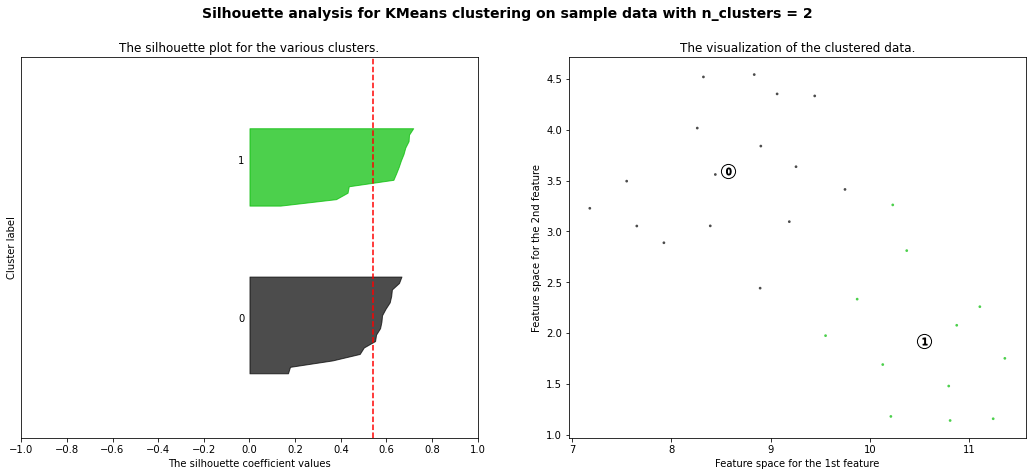

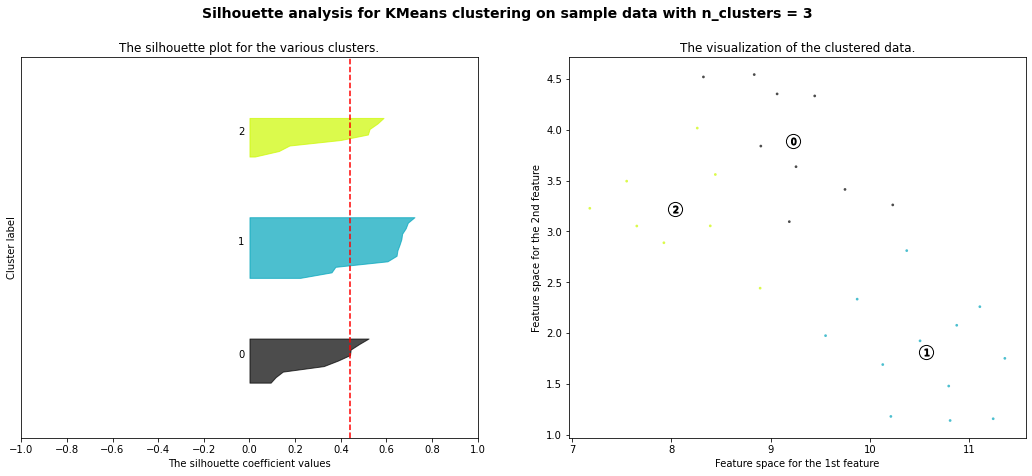

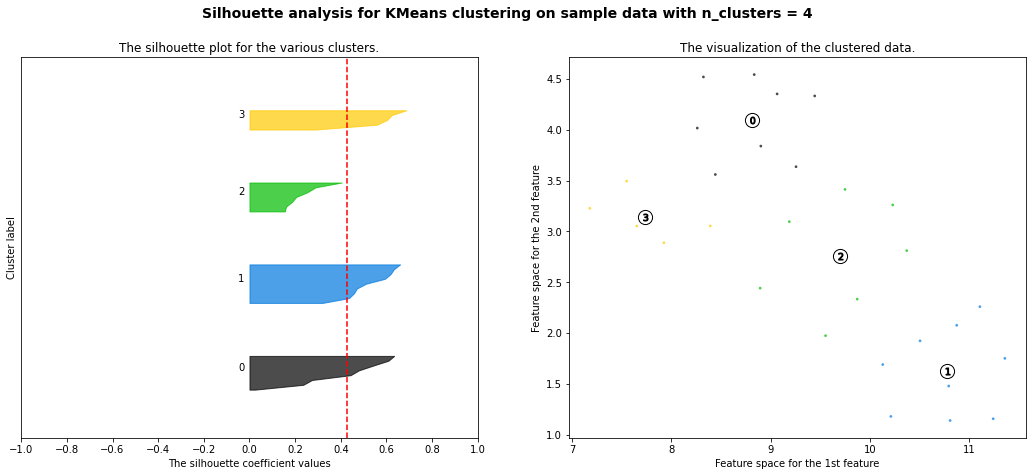

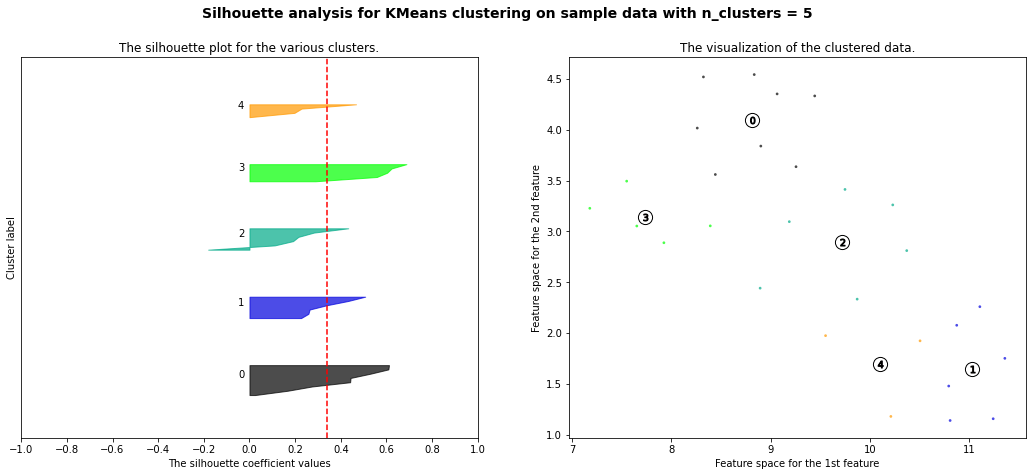

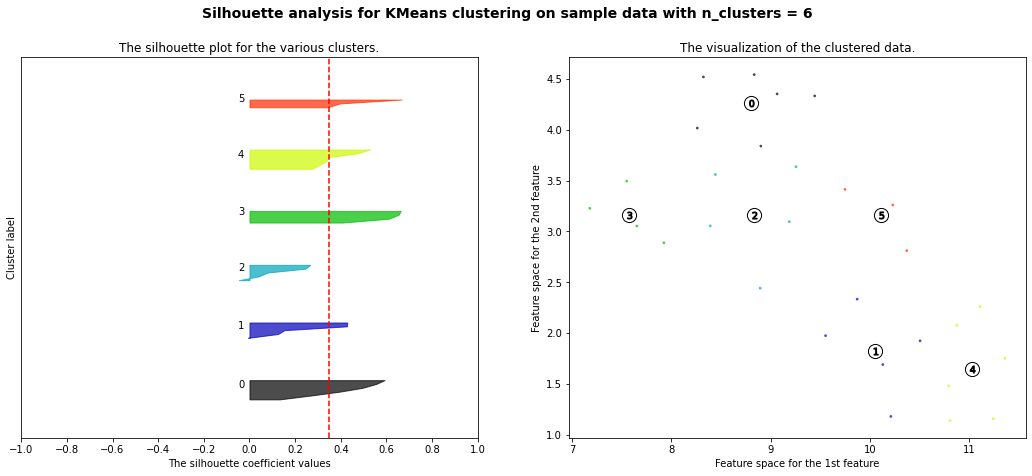

In [113]:
# umap
x_utility_umap = apply_umap(x_utility, 2)
# kmeans_clustering_elbow(x_utility_umap, total_k = 15)
silhouette_analysis([2, 3, 4, 5, 6], x_utility_umap)

In [114]:
# TO-DO: Mirar que significa esto: 
#    Generally, cluster validity measures are categorized into 3 classes 
#    (Internal cluster validation, External cluster validation and Relative cluster validation).

In [122]:
y_general, general_champions_list, general_principal_components = umap_kmeans(x_general, y_general, n_comps=2, k = 5 )
y_top, top_champions_list, top_principal_components = umap_kmeans(x_top, y_top, n_comps=2, k = 4 )
y_jungle, jungle_champions_list, jungle_principal_components = umap_kmeans(x_jungle, y_jungle, n_comps=2, k = 3 )
y_mid, mid_champions_list, mid_principal_components = umap_kmeans(x_mid, y_mid, n_comps=2, k = 4 )
y_bottom, bottom_champions_list, bottom_principal_components = umap_kmeans(x_bottom, y_bottom, n_comps=2, k = 6 )
y_utility, utility_champions_list, utility_principal_components = umap_kmeans(x_utility, y_utility, n_comps=2, k = 4 )

print_kmeans(y_utility)

1
Alistar
Blitzcrank
Galio
Leona
Maokai
Nautilus
Rell
Sett
TahmKench

0
Ashe
Karma
Lux
Pyke
Senna
Xerath

3
Bard
Braum
Morgana
Rakan
Renata
Thresh

2
Janna
Lulu
Nami
Seraphine
Sona
Soraka
Yuumi
Zilean

